In [1]:
import numpy as np
import torch
import torch.nn as nn
import gpytorch
import math
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from gpytorch.distributions import MultivariateNormal

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.float32
torch.set_default_dtype(dtype)

print(f"Using device: {device}")

Using device: cuda


In [2]:
# ============================================================
# 1. GEOSPATIAL-LIKE 2D DATA (ON A GRID)
# ============================================================

def generate_geospatial_grid(n_lon=35, n_lat=45, seed=0):  # *** CHANGED: n_lat=45 to match 35x45 grid
    """
    Synthetic 2D field on [0,1]^2 with:
    - non-stationary, non-separable structure
    - varying frequencies and amplitudes
    - heteroscedastic noise σ(x) as in the paper:
      σ(x) = 0.05 + 0.4 x1 + 0.3 x2^2 + 0.3 sin(3π x1 x2)
    """
    rng = np.random.RandomState(seed)
    torch.manual_seed(seed)

    lon = torch.linspace(0.0, 1.0, n_lon, device=device)
    lat = torch.linspace(0.0, 1.0, n_lat, device=device)

    Lon, Lat = torch.meshgrid(lon, lat, indexing="ij")  # shape: (n_lon, n_lat)

    # Large-scale meridional trend
    base_trend = 1.5 - 1.0 * Lat

    # Zonal band with localized latitudinal support
    zonal_band = (
        0.6
        * torch.sin(4 * math.pi * Lon)
        * torch.exp(-((Lat - 0.4) ** 2) / 0.02)
    )

    # Localized hotspot with high frequency and anisotropy
    hotspot = (
        0.9
        * torch.sin(10 * math.pi * Lon)
        * torch.exp(-(((Lon - 0.8) ** 2) + ((Lat - 0.2) ** 2)) / 0.01)
    )

    # Meridional structure in NE corner
    meridional = (
        0.8
        * torch.cos(6 * math.pi * Lat)
        * (Lon > 0.6).float()
        * (Lat > 0.5).float()
    )

    field_clean = base_trend + zonal_band + hotspot + meridional

    # *** CHANGED: heteroscedastic noise to match σ(x) in the paper
    # x1 = Lon, x2 = Lat
    noise_std = (
        0.05
        + 0.4 * Lon
        + 0.3 * (Lat ** 2)
        + 0.3 * torch.sin(3 * math.pi * Lon * Lat)
    )
    # Ensure positivity of std dev
    noise_std = torch.clamp(noise_std, min=1e-3)

    eps = torch.randn(n_lon, n_lat, device=device)
    field_noisy = field_clean + noise_std * eps

    X_all = torch.stack([Lon.reshape(-1), Lat.reshape(-1)], dim=-1)
    y_clean = field_clean.reshape(-1)
    y_noisy = field_noisy.reshape(-1)

    return X_all, y_clean, y_noisy, lon, lat, n_lon, n_lat

In [3]:
# ============================================================
# 2. LEARNABLE HYPERFUNCTIONS (1D) WITH Q OUTPUTS
# ============================================================

class LearnableHyperfunction1D(nn.Module):
    """
    1D hyperparameter function θ(x) via sparse GP interpolation.
    Supports vector-valued outputs θ(x) ∈ R^Q, used for GSM mixtures.
    """

    def __init__(self, inducing_x, init_scale=0.5, output_dim=1):  # *** CHANGED: output_dim
        super().__init__()
        M = inducing_x.shape[0]
        self.output_dim = output_dim
        self.register_buffer("inducing_x", inducing_x.clone())
        # Each inducing point has a Q-dimensional value
        self.inducing_vals = nn.Parameter(
            torch.randn(M, output_dim, device=device) * init_scale
        )
        self.log_lengthscale = nn.Parameter(
            torch.log(torch.tensor(0.3, device=device))
        )

    def rbf_kernel(self, x1, x2):
        ls = torch.exp(self.log_lengthscale)
        x1_scaled = x1 / ls
        x2_scaled = x2.t() / ls
        sqdist = (
            x1_scaled.pow(2).sum(-1, keepdim=True)
            + x2_scaled.pow(2).sum(0, keepdim=True)
            - 2 * x1_scaled @ x2_scaled
        )
        return torch.exp(-0.5 * sqdist)

    def forward(self, x):
        """
        x: (N, 1) -> returns (N, Q)
        """
        x = x.view(-1, 1)
        K_uu = self.rbf_kernel(self.inducing_x, self.inducing_x)
        K_uu = K_uu + 1e-4 * torch.eye(K_uu.size(0), device=device)
        K_xu = self.rbf_kernel(x, self.inducing_x)
        L_uu = torch.linalg.cholesky(K_uu)

        # Solve for each output dimension jointly:
        # inducing_vals: (M, Q) -> alpha: (M, Q)
        alpha = torch.cholesky_solve(self.inducing_vals, L_uu)

        # (N, M) @ (M, Q) -> (N, Q)
        return K_xu @ alpha

In [4]:
# ============================================================
# 3. FACTORIZED GSM KERNEL (NON-STATIONARY, Q-MIXTURE)
# ============================================================

class GSMFactorizedKernel2D(gpytorch.kernels.Kernel):
    """
    Non-stationary GSM kernel factorized over lon/lat, with
    location-dependent amplitude w_q(x), frequency μ_q(x),
    and lengthscale ℓ_q(x) for q = 1,...,Q mixtures.
    """
    is_stationary = False

    def __init__(
        self,
        hyper_w_lon, hyper_mu_lon, hyper_ell_lon,
        hyper_w_lat, hyper_mu_lat, hyper_ell_lat,
        num_mixtures=5,  # *** CHANGED: explicit Q
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.hyper_w_lon = hyper_w_lon
        self.hyper_mu_lon = hyper_mu_lon
        self.hyper_ell_lon = hyper_ell_lon
        self.hyper_w_lat = hyper_w_lat
        self.hyper_mu_lat = hyper_mu_lat
        self.hyper_ell_lat = hyper_ell_lat
        self.num_mixtures = num_mixtures

    @staticmethod
    def transform_w(raw):
        # Positive weights with moderate range
        return 0.3 + 1.7 * torch.sigmoid(raw)

    @staticmethod
    def transform_mu(raw):
        # Frequencies bounded to a reasonable positive range
        return 0.2 + 2.8 * torch.sigmoid(raw)

    @staticmethod
    def transform_ell(raw):
        # Lengthscales positive and bounded
        return 0.05 + 0.75 * torch.sigmoid(raw)

    def _gsm_1d(self, x1, x2, hyper_w, hyper_mu, hyper_ell):
        """
        1D GSM kernel with Q mixtures:
          k_1D(x1, x2) = sum_q w_q(x1) w_q(x2)
                               * exp(-2 π² (x1 - x2)² / ℓ̄_q² )
                               * cos(2 π μ̄_q (x1 - x2))
        where μ̄_q, ℓ̄_q are local averages across x1,x2.
        """
        N, M = x1.shape[0], x2.shape[0]

        raw_w1 = hyper_w(x1)  # (N, Q)
        raw_w2 = hyper_w(x2)  # (M, Q)
        raw_mu1 = hyper_mu(x1)  # (N, Q)
        raw_mu2 = hyper_mu(x2)  # (M, Q)
        raw_ell1 = hyper_ell(x1)  # (N, Q)
        raw_ell2 = hyper_ell(x2)  # (M, Q)

        w1 = self.transform_w(raw_w1)  # (N, Q)
        w2 = self.transform_w(raw_w2)  # (M, Q)
        mu1 = self.transform_mu(raw_mu1)  # (N, Q)
        mu2 = self.transform_mu(raw_mu2)  # (M, Q)
        ell1 = self.transform_ell(raw_ell1)  # (N, Q)
        ell2 = self.transform_ell(raw_ell2)  # (M, Q)

        # Pairwise differences
        dx = x1.expand(N, M) - x2.t().expand(N, M)  # (N, M)
        dx = dx.unsqueeze(-1)  # (N, M, 1)

        # Broadcast over Q mixtures
        w1_e = w1.unsqueeze(1)  # (N, 1, Q)
        w2_e = w2.unsqueeze(0)  # (1, M, Q)
        w_prod = w1_e * w2_e    # (N, M, Q)

        mu1_e = mu1.unsqueeze(1)  # (N, 1, Q)
        mu2_e = mu2.unsqueeze(0)  # (1, M, Q)
        mu_bar = 0.5 * (mu1_e + mu2_e)  # (N, M, Q)

        ell1_e = ell1.unsqueeze(1)  # (N, 1, Q)
        ell2_e = ell2.unsqueeze(0)  # (1, M, Q)
        ell_bar = 0.5 * (ell1_e + ell2_e)  # (N, M, Q)

        exp_term = torch.exp(-2 * math.pi**2 * dx**2 / (ell_bar**2 + 1e-6))
        cos_term = torch.cos(2 * math.pi * mu_bar * dx)
        K_q = w_prod * exp_term * cos_term  # (N, M, Q)

        # Sum over mixture components
        return K_q.sum(dim=2)  # (N, M)

    def forward(self, x1, x2, diag=False, **params):
        x1 = x1.view(-1, 2)
        x2 = x2.view(-1, 2)
        lon1, lat1 = x1[:, 0:1], x1[:, 1:2]
        lon2, lat2 = x2[:, 0:1], x2[:, 1:2]

        K_lon = self._gsm_1d(
            lon1, lon2,
            self.hyper_w_lon, self.hyper_mu_lon, self.hyper_ell_lon
        )
        K_lat = self._gsm_1d(
            lat1, lat2,
            self.hyper_w_lat, self.hyper_mu_lat, self.hyper_ell_lat
        )

        K = K_lon * K_lat  # Factorized GSM

        if diag:
            return K.diag()

        if K.shape[0] == K.shape[1]:
            K = K + 1e-3 * torch.eye(K.shape[0], device=device)

        return K

In [5]:
# ============================================================
# 4. STATIONARY SM KERNEL (BASELINE)
# ============================================================

class SMStationaryKernel2D(gpytorch.kernels.Kernel):
    is_stationary = True

    def __init__(self, Q=5, **kwargs):  # *** CHANGED: default Q=5
        super().__init__(**kwargs)
        self.Q = Q
        self.log_weights = nn.Parameter(torch.randn(Q) * 0.1)
        self.log_mus = nn.Parameter(torch.randn(Q))
        self.log_vs = nn.Parameter(torch.randn(Q) - 1.0)

    def forward(self, x1, x2, diag=False, **params):
        x1 = x1.view(-1, 2)
        x2 = x2.view(-1, 2)
        dist = torch.cdist(x1, x2)

        w = torch.exp(self.log_weights)
        mu = torch.exp(self.log_mus)
        v = torch.exp(self.log_vs)

        K = torch.zeros_like(dist)
        for q in range(self.Q):
            K += w[q] * torch.exp(-2 * math.pi**2 * v[q] * dist**2) * torch.cos(
                2 * math.pi * mu[q] * dist
            )

        if diag:
            return K.diag()

        if x1.shape[0] == x2.shape[0]:
            K = K + 1e-4 * torch.eye(K.shape[0], device=device)

        return K

In [6]:
# ============================================================
# 5. GP MODELS
# ============================================================

class GSMGP2D(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        return MultivariateNormal(
            self.mean_module(x),
            self.covar_module(x)
        )


class SMGP2D(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood, kernel):
        super().__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = kernel

    def forward(self, x):
        return MultivariateNormal(
            self.mean_module(x),
            self.covar_module(x)
        )

In [7]:
# ============================================================
# 6. GSM ENSEMBLE (POSTERIOR OVER ψ) + ACQUISITIONS
# ============================================================

class GSMEnsemble:
    """
    Ensemble of GSM models approximating p(ψ | D) by K MAP modes.
    Provides:
      - MC estimate of epistemic variance Var_ψ[ μ_ψ(x) ] (α_MC-EV).
      - Predictive variance for a fixed ψ (BALD-style baseline).
      - Hyperparameter variance across space (for analysis).
    """

    def __init__(
        self,
        ensemble_size=6,
        num_inducing=8,
        num_mixtures=5,   # *** CHANGED: Q for GSM
        map_iters=150,
        lr=0.03,
    ):
        self.ensemble_size = ensemble_size
        self.num_inducing = num_inducing
        self.num_mixtures = num_mixtures
        self.map_iters = map_iters
        self.lr = lr
        self.members = []

    def _init_model(self, train_x, train_y):
        ind_lon = torch.linspace(0.0, 1.0, self.num_inducing, device=device).view(-1, 1)
        ind_lat = torch.linspace(0.0, 1.0, self.num_inducing, device=device).view(-1, 1)

        # *** CHANGED: hyperfunctions now have output_dim = num_mixtures
        hyper_w_lon = LearnableHyperfunction1D(ind_lon, output_dim=self.num_mixtures).to(device)
        hyper_mu_lon = LearnableHyperfunction1D(ind_lon, output_dim=self.num_mixtures).to(device)
        hyper_ell_lon = LearnableHyperfunction1D(ind_lon, output_dim=self.num_mixtures).to(device)

        hyper_w_lat = LearnableHyperfunction1D(ind_lat, output_dim=self.num_mixtures).to(device)
        hyper_mu_lat = LearnableHyperfunction1D(ind_lat, output_dim=self.num_mixtures).to(device)
        hyper_ell_lat = LearnableHyperfunction1D(ind_lat, output_dim=self.num_mixtures).to(device)

        kernel = GSMFactorizedKernel2D(
            hyper_w_lon, hyper_mu_lon, hyper_ell_lon,
            hyper_w_lat, hyper_mu_lat, hyper_ell_lat,
            num_mixtures=self.num_mixtures,
        ).to(device)

        likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
        model = GSMGP2D(train_x, train_y, likelihood, kernel).to(device)
        return model, likelihood

    def build(self, train_x, train_y):
        print("\n" + "="*60)
        print("BUILDING GSM ENSEMBLE (multi-start MAP)")
        print("="*60)

        self.members = []

        for m in range(self.ensemble_size):
            print(f"\n  >>> Training GSM member {m+1}/{self.ensemble_size}")
            model, likelihood = self._init_model(train_x, train_y)

            model.train()
            likelihood.train()

            optimizer = torch.optim.Adam(model.parameters(), lr=self.lr)
            mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

            for it in range(1, self.map_iters + 1):
                optimizer.zero_grad()
                with gpytorch.settings.cholesky_jitter(1e-2):
                    out = model(train_x)
                    loss = -mll(out, train_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()

                if it % 50 == 0 or it == self.map_iters:
                    print(f"    iter {it}/{self.map_iters}, loss={loss.item():.4f}")

            model.eval()
            likelihood.eval()
            self.members.append((model, likelihood))

        print("\n✓ Ensemble built.")

    @torch.no_grad()
    def ensemble_predict_means(self, X, batch_size=512):
        """
        Compute μ_ψk(x) for each ensemble member k and all x in X.
        Returns tensor of shape (K, N).
        """
        M = len(self.members)
        N = X.shape[0]
        means = []

        for (model, likelihood) in self.members:
            preds = []
            for i in range(0, N, batch_size):
                xb = X[i:i+batch_size]
                with gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-2):
                    out = likelihood(model(xb))
                preds.append(out.mean.detach())
            means.append(torch.cat(preds, dim=0))

        return torch.stack(means, dim=0)

    @torch.no_grad()
    def mc_epistemic_variance(self, X, batch_size=512):
        """
        α_MC-EV(x): Monte Carlo estimate of Var_ψ[ μ_ψ(x) ] using the ensemble.
        This is the parameter-information acquisition described in the paper.
        """
        means = self.ensemble_predict_means(X, batch_size=batch_size)
        return means.var(dim=0, unbiased=True)

    @torch.no_grad()
    def predictive_variance_single_model(self, X, member_index=0, batch_size=512):
        """
        BALD-style baseline: predictive variance with fixed ψ.
        """
        model, likelihood = self.members[member_index]
        N = X.shape[0]
        vars_ = []

        for i in range(0, N, batch_size):
            xb = X[i:i+batch_size]
            with gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-2):
                out = likelihood(model(xb))
            vars_.append(out.variance.detach())

        return torch.cat(vars_, dim=0)

    @torch.no_grad()
    def parameter_disagreement_decomposed(self, X):
        """
        Hyperparameter variance Var(w(x)), Var(μ(x)), Var(ℓ(x)) for lon/lat.
        Aggregates across mixtures to yield one scalar per location.
        """
        N = X.shape[0]
        lon = X[:, 0:1]
        lat = X[:, 1:2]

        w_lon_all = []
        mu_lon_all = []
        ell_lon_all = []
        w_lat_all = []
        mu_lat_all = []
        ell_lat_all = []

        for (model, likelihood) in self.members:
            k = model.covar_module

            raw_w_lon = k.hyper_w_lon(lon)  # (N, Q)
            raw_mu_lon = k.hyper_mu_lon(lon)
            raw_ell_lon = k.hyper_ell_lon(lon)

            w_lon = GSMFactorizedKernel2D.transform_w(raw_w_lon)
            mu_lon = GSMFactorizedKernel2D.transform_mu(raw_mu_lon)
            ell_lon = GSMFactorizedKernel2D.transform_ell(raw_ell_lon)

            w_lon_all.append(w_lon)
            mu_lon_all.append(mu_lon)
            ell_lon_all.append(ell_lon)

            raw_w_lat = k.hyper_w_lat(lat)
            raw_mu_lat = k.hyper_mu_lat(lat)
            raw_ell_lat = k.hyper_ell_lat(lat)

            w_lat = GSMFactorizedKernel2D.transform_w(raw_w_lat)
            mu_lat = GSMFactorizedKernel2D.transform_mu(raw_mu_lat)
            ell_lat = GSMFactorizedKernel2D.transform_ell(raw_ell_lat)

            w_lat_all.append(w_lat)
            mu_lat_all.append(mu_lat)
            ell_lat_all.append(ell_lat)

        w_lon_all = torch.stack(w_lon_all, dim=0)   # (K, N, Q)
        mu_lon_all = torch.stack(mu_lon_all, dim=0) # (K, N, Q)
        ell_lon_all = torch.stack(ell_lon_all, dim=0)
        w_lat_all = torch.stack(w_lat_all, dim=0)
        mu_lat_all = torch.stack(mu_lat_all, dim=0)
        ell_lat_all = torch.stack(ell_lat_all, dim=0)

        # Variance across ensemble, then mean over mixtures -> (N,)
        var_w_lon = w_lon_all.var(dim=0, unbiased=True).mean(dim=1)
        var_mu_lon = mu_lon_all.var(dim=0, unbiased=True).mean(dim=1)
        var_ell_lon = ell_lon_all.var(dim=0, unbiased=True).mean(dim=1)
        var_w_lat = w_lat_all.var(dim=0, unbiased=True).mean(dim=1)
        var_mu_lat = mu_lat_all.var(dim=0, unbiased=True).mean(dim=1)
        var_ell_lat = ell_lat_all.var(dim=0, unbiased=True).mean(dim=1)

        return {
            'w_lon': var_w_lon,
            'mu_lon': var_mu_lon,
            'ell_lon': var_ell_lon,
            'w_lat': var_w_lat,
            'mu_lat': var_mu_lat,
            'ell_lat': var_ell_lat,
        }

In [8]:
# ============================================================
# 7. SM BASELINE TRAINING
# ============================================================

def train_sm_baseline(train_x, train_y, Q=5, iters=150, lr=0.05):  # *** CHANGED: Q=5 default
    print("  Training SM baseline...")

    likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)

    kernel = gpytorch.kernels.SpectralMixtureKernel(
        num_mixtures=Q,
        ard_num_dims=2
    ).to(device)

    kernel.initialize_from_data(train_x, train_y)

    model = SMGP2D(train_x, train_y, likelihood, kernel).to(device)

    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    for it in range(1, iters + 1):
        optimizer.zero_grad()
        with gpytorch.settings.cholesky_jitter(1e-3):
            out = model(train_x)
            loss = -mll(out, train_y)
        loss.backward()
        optimizer.step()

        if it % 50 == 0 or it == iters:
            print(f"    SM iter {it}/{iters}, loss={loss.item():.4f}")

    model.eval()
    likelihood.eval()
    return model, likelihood

In [9]:
# ============================================================
# 8. HYPERPARAMETER UNCERTAINTY (COV(ψ))
# ============================================================

def extract_psi_vector(model):
    k = model.covar_module
    params = [
        k.hyper_w_lon.inducing_vals.view(-1),
        k.hyper_mu_lon.inducing_vals.view(-1),
        k.hyper_ell_lon.inducing_vals.view(-1),
        k.hyper_w_lat.inducing_vals.view(-1),
        k.hyper_mu_lat.inducing_vals.view(-1),
        k.hyper_ell_lat.inducing_vals.view(-1),
    ]
    psi = torch.cat(params, dim=0)
    return psi.detach().cpu()


def hyper_param_uncertainty(ensemble):
    psi_list = []
    for (model, likelihood) in ensemble.members:
        psi_list.append(extract_psi_vector(model))

    Psi = torch.stack(psi_list, dim=0)
    Psi_center = Psi - Psi.mean(dim=0, keepdim=True)

    Cov = Psi_center.t() @ Psi_center / (Psi.size(0) - 1 + 1e-8)

    trace = Cov.diag().sum().item()
    jitter = 1e-6 * torch.eye(Cov.size(0))
    sign, logdet = torch.linalg.slogdet(Cov + jitter)
    return trace, logdet.item()

In [10]:
# ============================================================
# 9. COMPREHENSIVE PLOTTING FUNCTIONS
# ============================================================

def plot_hyperparameter_uncertainty_grid(ensemble, X_all, n_lon, n_lat, iter_idx, 
                                         train_x=None, save_path=None):
    """
    Plot 2D heatmaps showing variance of each hyperparameter across space.
    """
    var_dict = ensemble.parameter_disagreement_decomposed(X_all)
    
    fig = plt.figure(figsize=(18, 10))
    gs = GridSpec(2, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    titles = ['Var[w(lon)]', 'Var[μ(lon)]', 'Var[ℓ(lon)]',
              'Var[w(lat)]', 'Var[μ(lat)]', 'Var[ℓ(lat)]']
    keys = ['w_lon', 'mu_lon', 'ell_lon', 'w_lat', 'mu_lat', 'ell_lat']
    
    for idx, (key, title) in enumerate(zip(keys, titles)):
        ax = fig.add_subplot(gs[idx // 3, idx % 3])
        
        data = var_dict[key].cpu().numpy().reshape(n_lon, n_lat).T
        
        im = ax.imshow(data, origin='lower', extent=[0, 1, 0, 1],
                       aspect='auto', cmap='plasma')
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('lon_norm')
        ax.set_ylabel('lat_norm')
        
        if train_x is not None:
            train_np = train_x.cpu().numpy()
            ax.scatter(train_np[:, 0], train_np[:, 1],
                       c='white', s=5, alpha=0.6, edgecolors='black', linewidths=0.3)
        
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    fig.suptitle(f'Hyperparameter Uncertainty Heatmaps (AL iter {iter_idx})', 
                 fontsize=14, fontweight='bold', y=0.98)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [11]:
def plot_acquisition_comparison(ensemble, X_all, n_lon, n_lat, iter_idx, 
                                train_x=None, save_path=None):
    """
    Compare parameter-information (MC-EV) vs predictive-variance (BALD-style) acquisitions.
    Both are evaluated on the FULL GRID X_all (size n_lon * n_lat).
    """
    param_acq = ensemble.mc_epistemic_variance(X_all)
    pred_acq = ensemble.predictive_variance_single_model(X_all, member_index=0)
    
    param_acq_norm = (param_acq - param_acq.min()) / (param_acq.max() - param_acq.min() + 1e-8)
    pred_acq_norm = (pred_acq - pred_acq.min()) / (pred_acq.max() - pred_acq.min() + 1e-8)
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    param_grid = param_acq_norm.cpu().numpy().reshape(n_lon, n_lat).T
    im0 = axes[0].imshow(param_grid, origin='lower', extent=[0, 1, 0, 1],
                         aspect='auto', cmap='viridis')
    axes[0].set_title('MC-EV (Param Info Proxy)\nVar_ψ[μ_ψ(x)]', 
                      fontsize=12, fontweight='bold')
    axes[0].set_xlabel('lon_norm')
    axes[0].set_ylabel('lat_norm')
    if train_x is not None:
        train_np = train_x.cpu().numpy()
        axes[0].scatter(train_np[:, 0], train_np[:, 1],
                        c='red', s=10, alpha=0.7, edgecolors='white', linewidths=0.5)
    plt.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
    
    pred_grid = pred_acq_norm.cpu().numpy().reshape(n_lon, n_lat).T
    im1 = axes[1].imshow(pred_grid, origin='lower', extent=[0, 1, 0, 1],
                         aspect='auto', cmap='viridis')
    axes[1].set_title('Predictive Variance (BALD-style)\nσ_pred^2(x)', 
                      fontsize=12, fontweight='bold')
    axes[1].set_xlabel('lon_norm')
    axes[1].set_ylabel('lat_norm')
    if train_x is not None:
        axes[1].scatter(train_np[:, 0], train_np[:, 1],
                        c='red', s=10, alpha=0.7, edgecolors='white', linewidths=0.5)
    plt.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
    
    diff_grid = (param_grid - pred_grid)
    im2 = axes[2].imshow(diff_grid, origin='lower', extent=[0, 1, 0, 1],
                         aspect='auto', cmap='RdBu_r', vmin=-1, vmax=1)
    axes[2].set_title('Difference\n(MC-EV - Pred Var)', 
                      fontsize=12, fontweight='bold')
    axes[2].set_xlabel('lon_norm')
    axes[2].set_ylabel('lat_norm')
    if train_x is not None:
        axes[2].scatter(train_np[:, 0], train_np[:, 1],
                        c='yellow', s=10, alpha=0.7, edgecolors='black', linewidths=0.5)
    plt.colorbar(im2, ax=axes[2], fraction=0.046, pad=0.04)
    
    fig.suptitle(f'Acquisition Function Comparison (AL iter {iter_idx})', 
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [12]:
def plot_learning_curves_comparison(results_param, results_pred, save_path=None):
    fig = plt.figure(figsize=(16, 10))
    gs = GridSpec(3, 3, figure=fig, hspace=0.3, wspace=0.3)
    
    iters_p = results_param["iter"]
    iters_pred = results_pred["iter"]
    
    ax0 = fig.add_subplot(gs[0, 0])
    ax0.plot(iters_p, results_param["mse_gsm"], 'o-', label='MC-EV (Param-based)', 
             linewidth=2, markersize=6)
    ax0.plot(iters_pred, results_pred["mse_gsm"], 's--', label='Pred Var (Baseline)', 
             linewidth=2, markersize=6)
    ax0.set_xlabel("AL iteration", fontsize=11)
    ax0.set_ylabel("GSM MSE", fontsize=11)
    ax0.set_title("Predictive Performance", fontsize=12, fontweight='bold')
    ax0.legend(fontsize=10)
    ax0.grid(True, alpha=0.3)
    
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(iters_p, results_param["trace_cov"], 'o-', 
             linewidth=2, markersize=6)
    ax1.plot(iters_pred, results_pred["trace_cov"], 's--', 
             linewidth=2, markersize=6)
    ax1.set_xlabel("AL iteration", fontsize=11)
    ax1.set_ylabel("trace(Cov(ψ))", fontsize=11)
    ax1.set_title("Hyperparameter Uncertainty (Trace)", fontsize=12, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    ax2 = fig.add_subplot(gs[0, 2])
    ax2.plot(iters_p, results_param["logdet_cov"], 'o-', 
             linewidth=2, markersize=6)
    ax2.plot(iters_pred, results_pred["logdet_cov"], 's--', 
             linewidth=2, markersize=6)
    ax2.set_xlabel("AL iteration", fontsize=11)
    ax2.set_ylabel("logdet(Cov(ψ))", fontsize=11)
    ax2.set_title("Hyperparameter Uncertainty (Logdet)", fontsize=12, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    ax3 = fig.add_subplot(gs[1, 0])
    improvement_p = [sm/gsm for sm, gsm in zip(results_param["mse_sm"], results_param["mse_gsm"])]
    improvement_pred = [sm/gsm for sm, gsm in zip(results_pred["mse_sm"], results_pred["mse_gsm"])]
    ax3.plot(iters_p, improvement_p, 'o-', linewidth=2, markersize=6)
    ax3.plot(iters_pred, improvement_pred, 's--', linewidth=2, markersize=6)
    ax3.axhline(y=1.0, color='red', linestyle=':', linewidth=2, label='SM baseline')
    ax3.set_xlabel("AL iteration", fontsize=11)
    ax3.set_ylabel("SM MSE / GSM MSE", fontsize=11)
    ax3.set_title("Advantage over Stationary SM", fontsize=12, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    ax4 = fig.add_subplot(gs[1, 1])
    ax4.plot(iters_p, results_param["train_sizes"], 'o-', 
             linewidth=2, markersize=6)
    ax4.set_xlabel("AL iteration", fontsize=11)
    ax4.set_ylabel("Train set size", fontsize=11)
    ax4.set_title("Data Acquired", fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)
    
    ax5 = fig.add_subplot(gs[1, 2])
    mse_diff = [p - pred for p, pred in zip(results_param["mse_gsm"], results_pred["mse_gsm"])]
    ax5.plot(iters_p, mse_diff, 'o-', linewidth=2, markersize=6)
    ax5.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax5.set_xlabel("AL iteration", fontsize=11)
    ax5.set_ylabel("MSE(Param) - MSE(Pred)", fontsize=11)
    ax5.set_title("MSE Difference\n(negative = Param wins)", fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)
    
    ax6 = fig.add_subplot(gs[2, 0])
    trace_rate_p = np.diff(results_param["trace_cov"])
    trace_rate_pred = np.diff(results_pred["trace_cov"])
    ax6.plot(iters_p[1:], trace_rate_p, 'o-', linewidth=2, markersize=6)
    ax6.plot(iters_pred[1:], trace_rate_pred, 's--', linewidth=2, markersize=6)
    ax6.axhline(y=0, color='black', linestyle='--', linewidth=1)
    ax6.set_xlabel("AL iteration", fontsize=11)
    ax6.set_ylabel("Δ trace(Cov(ψ))", fontsize=11)
    ax6.set_title("Trace Reduction Rate", fontsize=12, fontweight='bold')
    ax6.grid(True, alpha=0.3)
    
    ax7 = fig.add_subplot(gs[2, 1])
    cum_mse_p = np.cumsum(results_param["mse_gsm"])
    cum_mse_pred = np.cumsum(results_pred["mse_gsm"])
    ax7.plot(iters_p, cum_mse_p, 'o-', linewidth=2, markersize=6)
    ax7.plot(iters_pred, cum_mse_pred, 's--', linewidth=2, markersize=6)
    ax7.set_xlabel("AL iteration", fontsize=11)
    ax7.set_ylabel("Cumulative MSE", fontsize=11)
    ax7.set_title("Cumulative Prediction Error", fontsize=12, fontweight='bold')
    ax7.grid(True, alpha=0.3)
    
    ax8 = fig.add_subplot(gs[2, 2])
    ax8.axis('off')
    
    final_mse_p = results_param["mse_gsm"][-1]
    final_mse_pred = results_pred["mse_gsm"][-1]
    final_trace_p = results_param["trace_cov"][-1]
    final_trace_pred = results_pred["trace_cov"][-1]
    
    table_data = [
        ['Metric', 'MC-EV (Param)', 'Pred Var (Baseline)', 'Winner'],
        ['Final MSE', f'{final_mse_p:.4f}', f'{final_mse_pred:.4f}', 
         'Param' if final_mse_p < final_mse_pred else 'Pred'],
        ['Final trace', f'{final_trace_p:.4f}', f'{final_trace_pred:.4f}',
         'Param' if final_trace_p < final_trace_pred else 'Pred'],
        ['Avg MSE', f'{np.mean(results_param["mse_gsm"]):.4f}', 
         f'{np.mean(results_pred["mse_gsm"]):.4f}',
         'Param' if np.mean(results_param["mse_gsm"]) < np.mean(results_pred["mse_gsm"]) else 'Pred'],
    ]
    
    table = ax8.table(cellText=table_data, cellLoc='center', loc='center',
                      colWidths=[0.25, 0.25, 0.25, 0.25])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    
    for i in range(4):
        table[(0, i)].set_facecolor('#E0E0E0')
        table[(0, i)].set_text_props(weight='bold')
    
    ax8.set_title("Summary Statistics", fontsize=12, fontweight='bold', pad=20)
    
    fig.suptitle('Parameter-based (MC-EV) vs Prediction-based (Pred Var) Active Learning', 
                 fontsize=16, fontweight='bold', y=0.995)
    
    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

In [13]:
# ============================================================
# 10. ACTIVE LEARNER
# ============================================================

class ActiveLearner:
    """
    acquisition='parameter'  -> MC-EV: Var_ψ[ μ_ψ(x) ]  (paper's proposal)
    acquisition='prediction' -> Predictive variance σ_pred^2(x) (BALD-style baseline)
    """

    def __init__(self, X_all, y_clean, y_noisy, lon_grid, lat_grid,
                 n_lon, n_lat, ensemble_size=6, num_mixtures=5,
                 acquisition='parameter'):
        self.X_all = X_all
        self.y_clean = y_clean
        self.y_noisy = y_noisy
        self.lon_grid = lon_grid
        self.lat_grid = lat_grid
        self.n_lon = n_lon
        self.n_lat = n_lat
        self.N = X_all.shape[0]
        
        self.acquisition = acquisition

        self.ensemble = GSMEnsemble(
            ensemble_size=ensemble_size,
            num_inducing=8,
            num_mixtures=num_mixtures,  # *** CHANGED: pass Q
            map_iters=150,
            lr=0.03,
        )

        self.mse_gsm_list = []
        self.mse_sm_list = []
        self.trace_list = []
        self.logdet_list = []
        self.train_sizes = []
        self.iter_ids = []

    def initialize(self, num_init=25, seed=0):
        torch.manual_seed(seed)
        perm = torch.randperm(self.N)
        self.train_idx = perm[:num_init].clone()
        self.pool_idx = perm[num_init:].clone()

        self.train_x = self.X_all[self.train_idx].clone()
        self.train_y = self.y_noisy[self.train_idx].clone()

        print(f"Initial training set size: {self.train_x.shape[0]}")
        print(f"Acquisition function: {self.acquisition}")

    def pick_next_point(self):
        X_pool = self.X_all[self.pool_idx]
        
        if self.acquisition == 'parameter':
            acq = self.ensemble.mc_epistemic_variance(X_pool)
            acq_name = "MC-EV (Param-Info Proxy)"
        elif self.acquisition == 'prediction':
            acq = self.ensemble.predictive_variance_single_model(X_pool, member_index=0)
            acq_name = "Predictive Variance (BALD-style)"
        else:
            raise ValueError(f"Unknown acquisition: {self.acquisition}")
        
        best_local = torch.argmax(acq)
        best_global_idx = self.pool_idx[best_local]
        
        print(f"  Acquired via {acq_name}: idx={best_global_idx.item()}, "
              f"score={acq[best_local].item():.4f}")
        
        return best_global_idx.item(), acq[best_local].item()

    def update_dataset(self, idx):
        self.train_x = torch.cat([self.train_x, self.X_all[idx:idx + 1]], dim=0)
        self.train_y = torch.cat([self.train_y, self.y_noisy[idx:idx + 1]], dim=0)
        self.pool_idx = self.pool_idx[self.pool_idx != idx]

    def run(self, num_init=25, num_steps=10, seed=0, plot_every=3):
        self.initialize(num_init=num_init, seed=seed)

        for t in range(1, num_steps + 1):
            print("\n" + "=" * 70)
            print(f"AL ITERATION {t}/{num_steps} ({self.acquisition.upper()})")
            print(f"Current train size: {self.train_x.shape[0]}")
            print("=" * 70)

            self.ensemble.build(self.train_x, self.train_y)
            sm_model, sm_lik = train_sm_baseline(self.train_x, self.train_y)

            with torch.no_grad():
                ens_means = self.ensemble.ensemble_predict_means(self.X_all)
                gsm_mean = ens_means.mean(dim=0)
                mse_gsm = torch.mean((gsm_mean - self.y_clean) ** 2).item()

                with gpytorch.settings.fast_pred_var(), gpytorch.settings.cholesky_jitter(1e-3):
                    out_sm = sm_lik(sm_model(self.X_all))
                sm_mean = out_sm.mean
                mse_sm = torch.mean((sm_mean - self.y_clean) ** 2).item()

            trace_psi, logdet_psi = hyper_param_uncertainty(self.ensemble)

            print(f"  GSM MSE: {mse_gsm:.4f}, SM MSE: {mse_sm:.4f}")
            print(f"  trace(Cov(ψ)): {trace_psi:.4f}, logdet(Cov(ψ)): {logdet_psi:.4f}")

            self.iter_ids.append(t)
            self.mse_gsm_list.append(mse_gsm)
            self.mse_sm_list.append(mse_sm)
            self.trace_list.append(trace_psi)
            self.logdet_list.append(logdet_psi)
            self.train_sizes.append(self.train_x.shape[0])

            if t % plot_every == 0 or t == 1:
                plot_hyperparameter_uncertainty_grid(
                    self.ensemble, self.X_all, self.n_lon, self.n_lat, t,
                    train_x=self.train_x,
                    save_path=f'hyperparam_uncertainty_{self.acquisition}_iter{t}.png'
                )
                
                plot_acquisition_comparison(
                    self.ensemble, self.X_all, self.n_lon, self.n_lat, t,
                    train_x=self.train_x,
                    save_path=f'acquisition_comparison_{self.acquisition}_iter{t}.png'
                )

            best_idx, _ = self.pick_next_point()
            self.update_dataset(best_idx)

        return {
            "iter": self.iter_ids,
            "mse_gsm": self.mse_gsm_list,
            "mse_sm": self.mse_sm_list,
            "trace_cov": self.trace_list,
            "logdet_cov": self.logdet_list,
            "train_sizes": self.train_sizes,
        }

PARAMETER-INFORMATION ACTIVE LEARNING (MC-EV) VS PREDICTIVE VARIANCE

Generating 2D geospatial-like dataset...
Full grid: 45 x 35 = 1575 points in [0,1]²

RUNNING: PARAMETER INFORMATION ACQUISITION (MC-EV)
Initial training set size: 100
Acquisition function: parameter

AL ITERATION 1/8 (PARAMETER)
Current train size: 100

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3580
    iter 100/150, loss=0.9249
    iter 150/150, loss=0.8208

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3374
    iter 100/150, loss=0.9165
    iter 150/150, loss=0.8183

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3155
    iter 100/150, loss=0.9066
    iter 150/150, loss=0.8086

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3504
    iter 100/150, loss=0.9523
    iter 150/150, loss=0.8405

  >>> Training GSM member 5/6
    iter 50/150, loss=1.2994
    iter 100/150, loss=0.9052
    iter 150/150, loss=0.8189

  >>> Training GSM member 6/6
    i

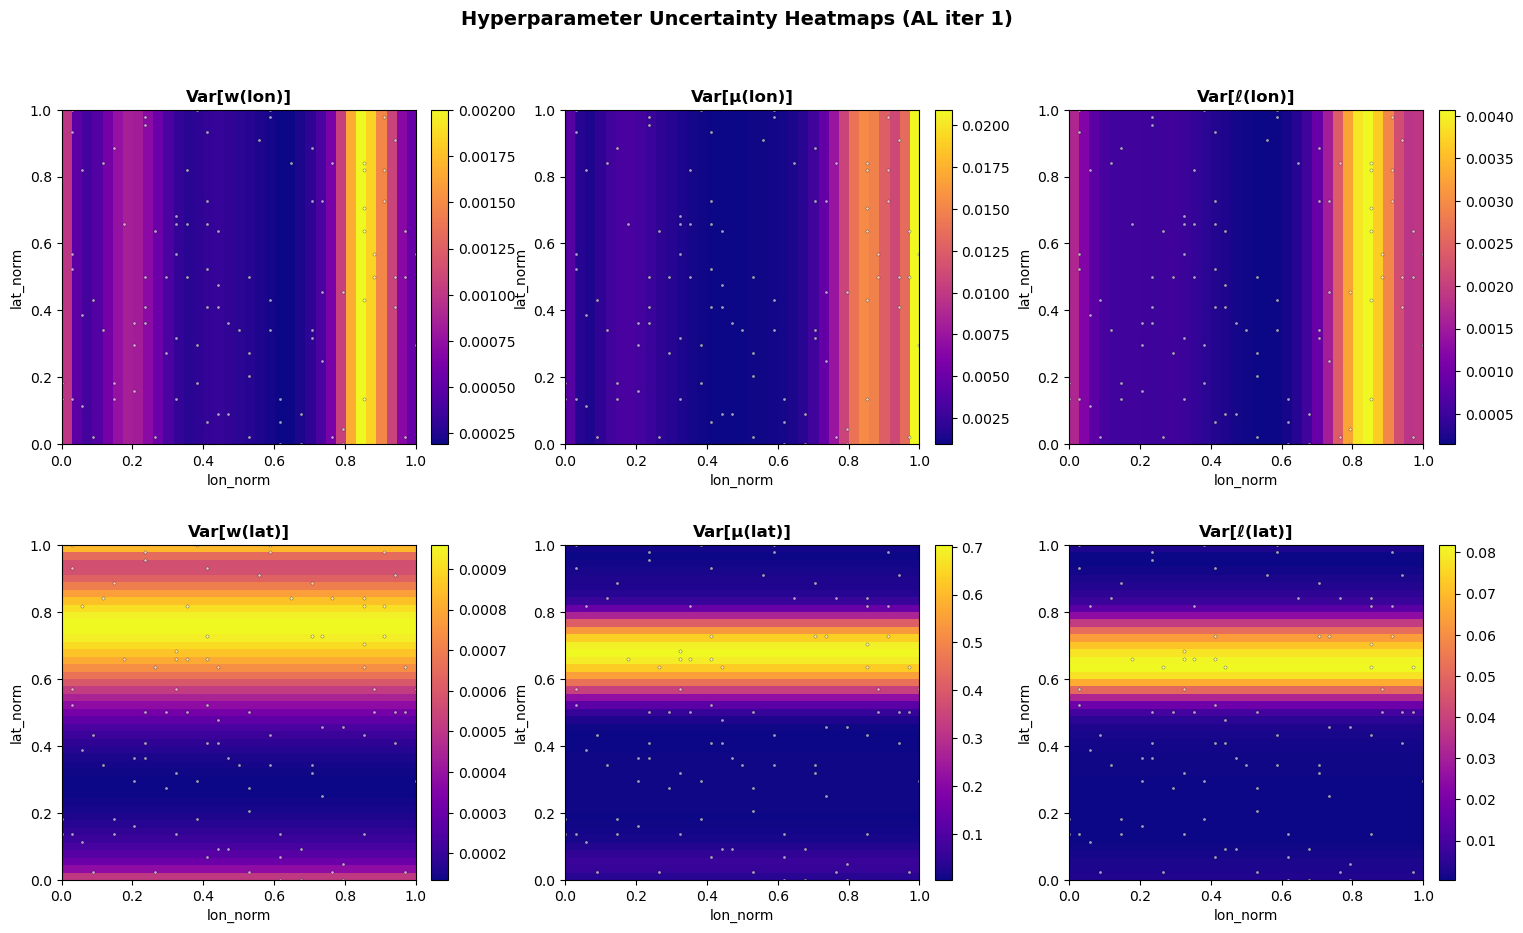

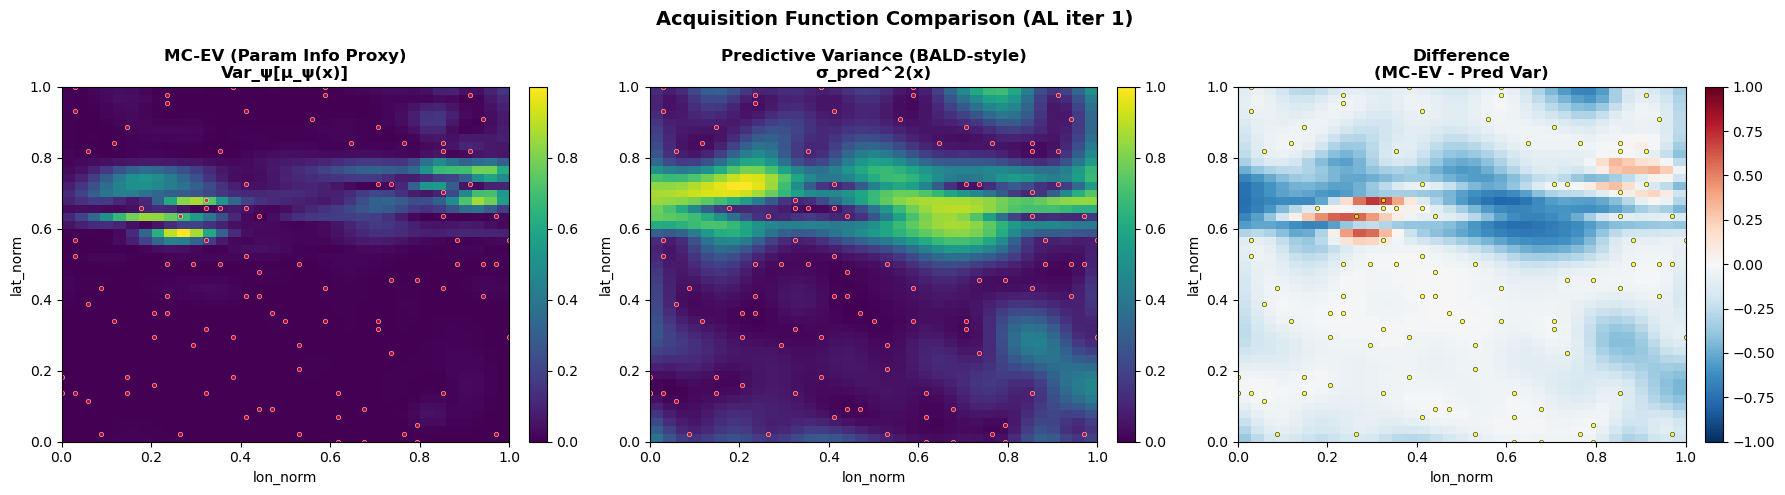

  Acquired via MC-EV (Param-Info Proxy): idx=431, score=0.0235

AL ITERATION 2/8 (PARAMETER)
Current train size: 101

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3275
    iter 100/150, loss=0.9423
    iter 150/150, loss=0.8550

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3481
    iter 100/150, loss=0.9482
    iter 150/150, loss=0.8639

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3022
    iter 100/150, loss=0.9192
    iter 150/150, loss=0.8379

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3187
    iter 100/150, loss=0.9369
    iter 150/150, loss=0.8268

  >>> Training GSM member 5/6
    iter 50/150, loss=1.3412
    iter 100/150, loss=0.9385
    iter 150/150, loss=0.8444

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3467
    iter 100/150, loss=0.9388
    iter 150/150, loss=0.8405

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.8382
    SM iter 100/150, loss=0.7304
    SM iter 

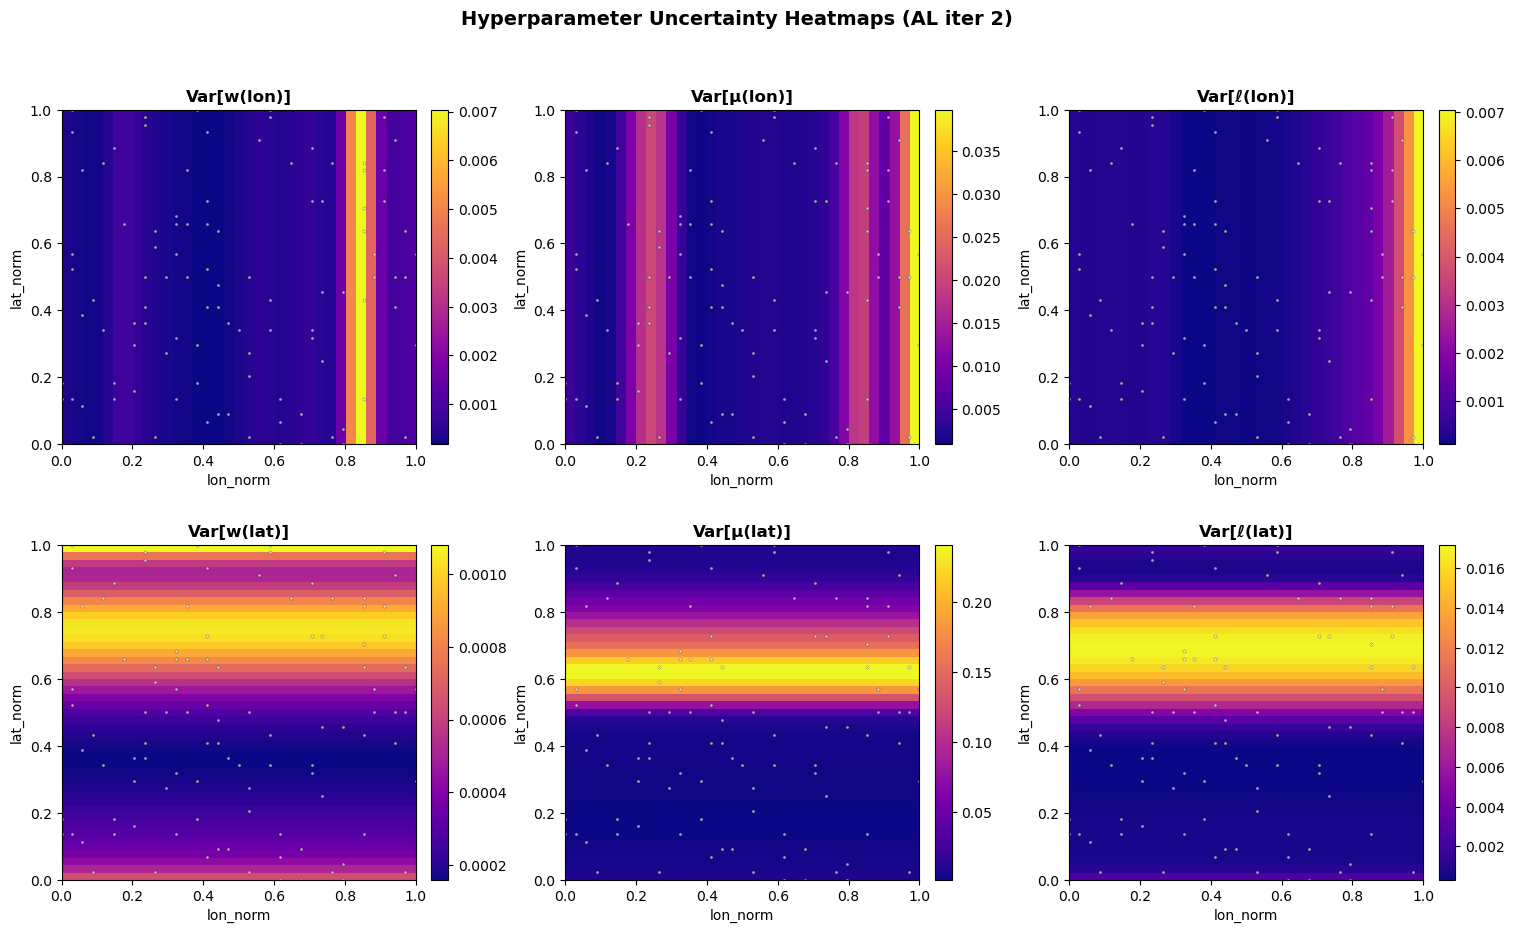

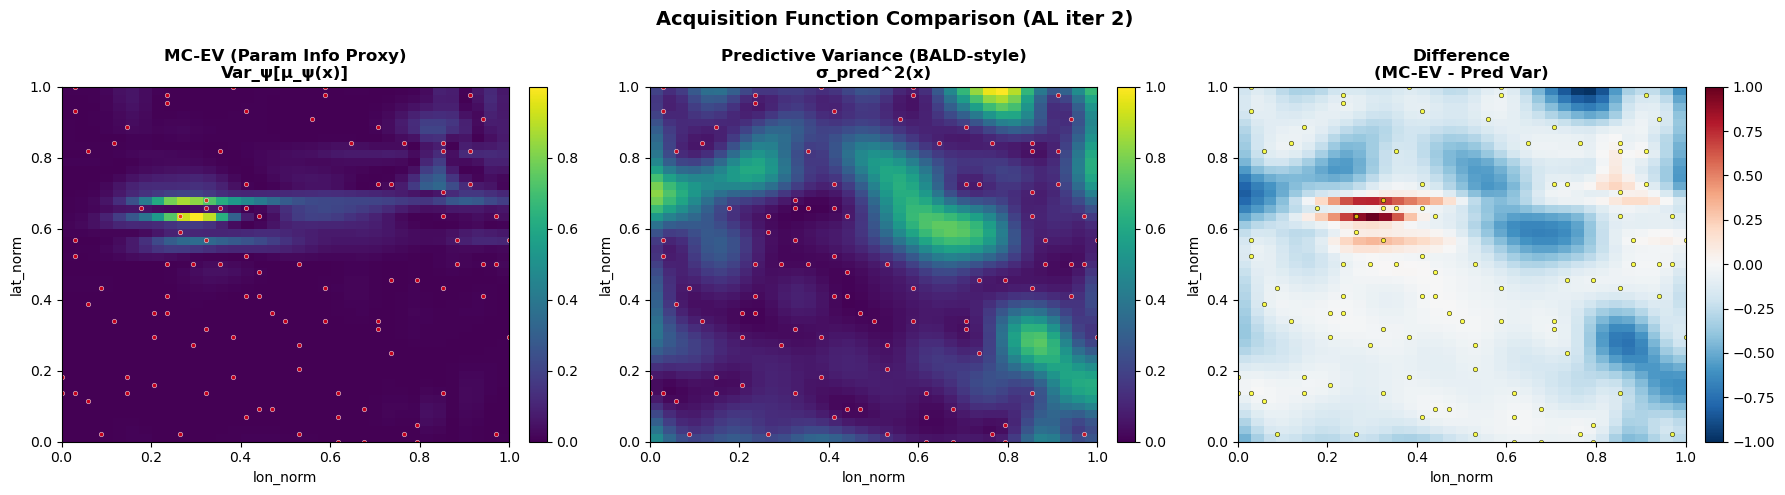

  Acquired via MC-EV (Param-Info Proxy): idx=478, score=0.0558

AL ITERATION 3/8 (PARAMETER)
Current train size: 102

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3318
    iter 100/150, loss=0.9366
    iter 150/150, loss=0.8526

  >>> Training GSM member 2/6
    iter 50/150, loss=1.2837
    iter 100/150, loss=0.9064
    iter 150/150, loss=0.8187

  >>> Training GSM member 3/6
    iter 50/150, loss=1.2881
    iter 100/150, loss=0.9293
    iter 150/150, loss=0.8461

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3045
    iter 100/150, loss=0.9322
    iter 150/150, loss=0.8513

  >>> Training GSM member 5/6
    iter 50/150, loss=1.2756
    iter 100/150, loss=0.9245
    iter 150/150, loss=0.8319

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3455
    iter 100/150, loss=0.9214
    iter 150/150, loss=0.8252

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.8646
    SM iter 100/150, loss=0.7253
    SM iter 

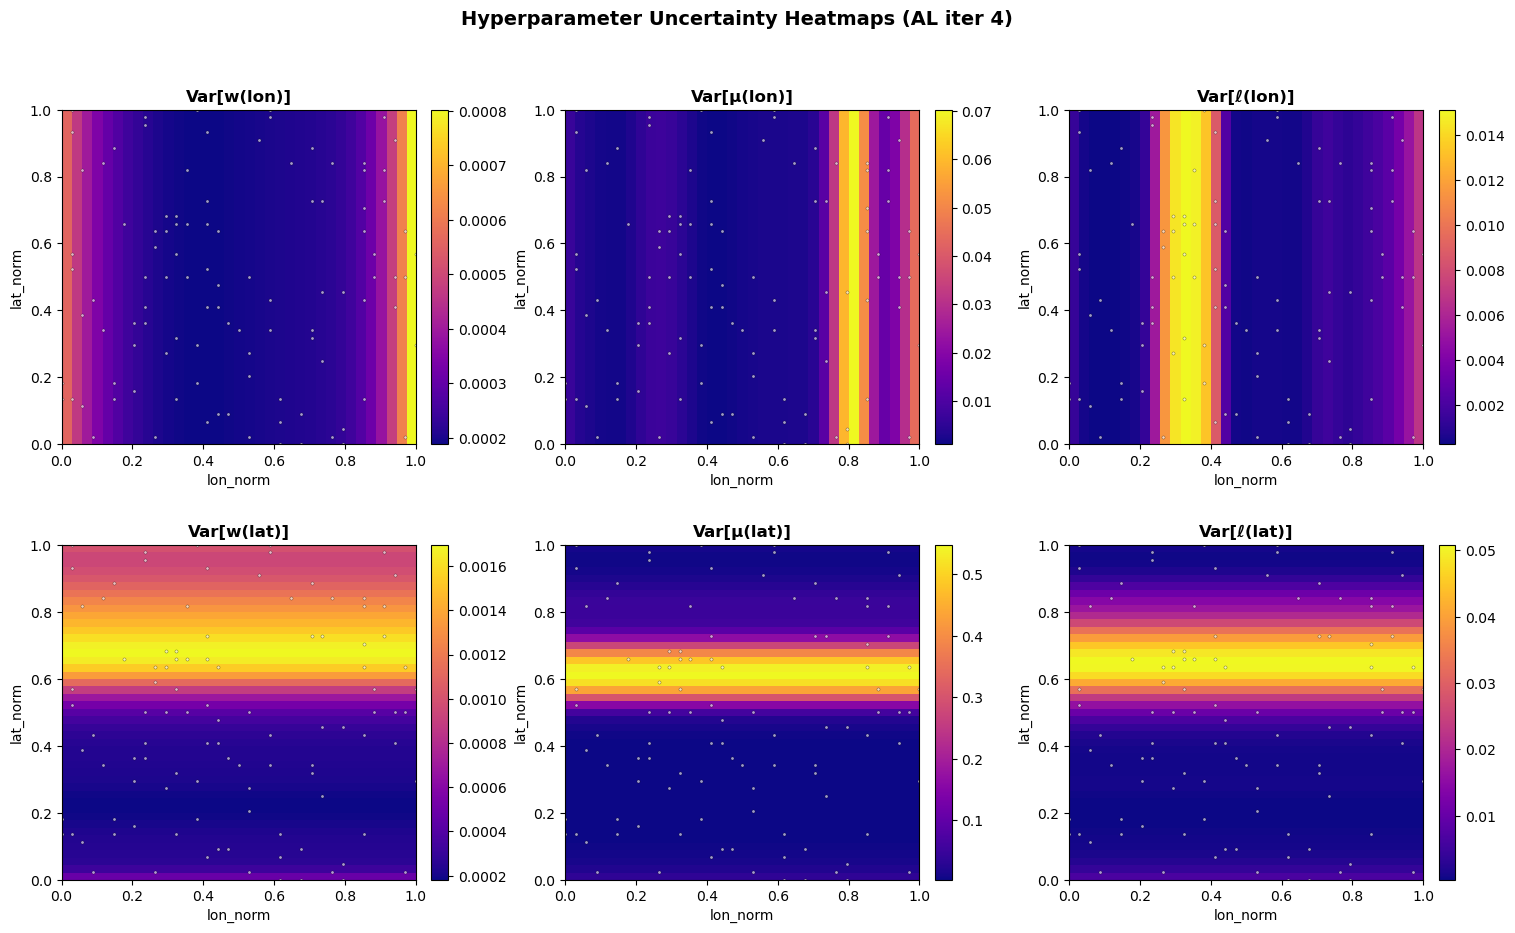

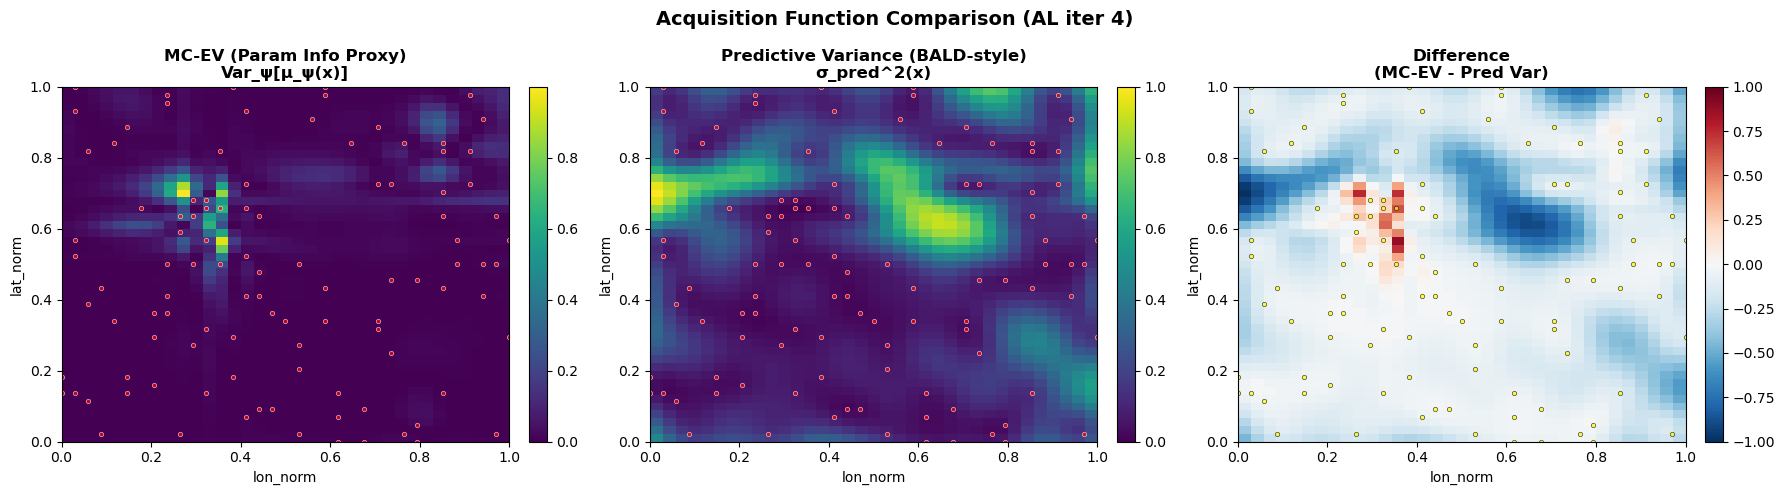

  Acquired via MC-EV (Param-Info Proxy): idx=436, score=0.0612

AL ITERATION 5/8 (PARAMETER)
Current train size: 104

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.2628
    iter 100/150, loss=0.9118
    iter 150/150, loss=0.8127

  >>> Training GSM member 2/6
    iter 50/150, loss=1.2874
    iter 100/150, loss=0.9114
    iter 150/150, loss=0.8100

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3474
    iter 100/150, loss=0.9185
    iter 150/150, loss=0.8145

  >>> Training GSM member 4/6
    iter 50/150, loss=1.2465
    iter 100/150, loss=0.8974
    iter 150/150, loss=0.8098

  >>> Training GSM member 5/6
    iter 50/150, loss=1.2581
    iter 100/150, loss=0.9141
    iter 150/150, loss=0.8131

  >>> Training GSM member 6/6
    iter 50/150, loss=1.2553
    iter 100/150, loss=0.8912
    iter 150/150, loss=0.8077

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.9208
    SM iter 100/150, loss=0.8025
    SM iter 

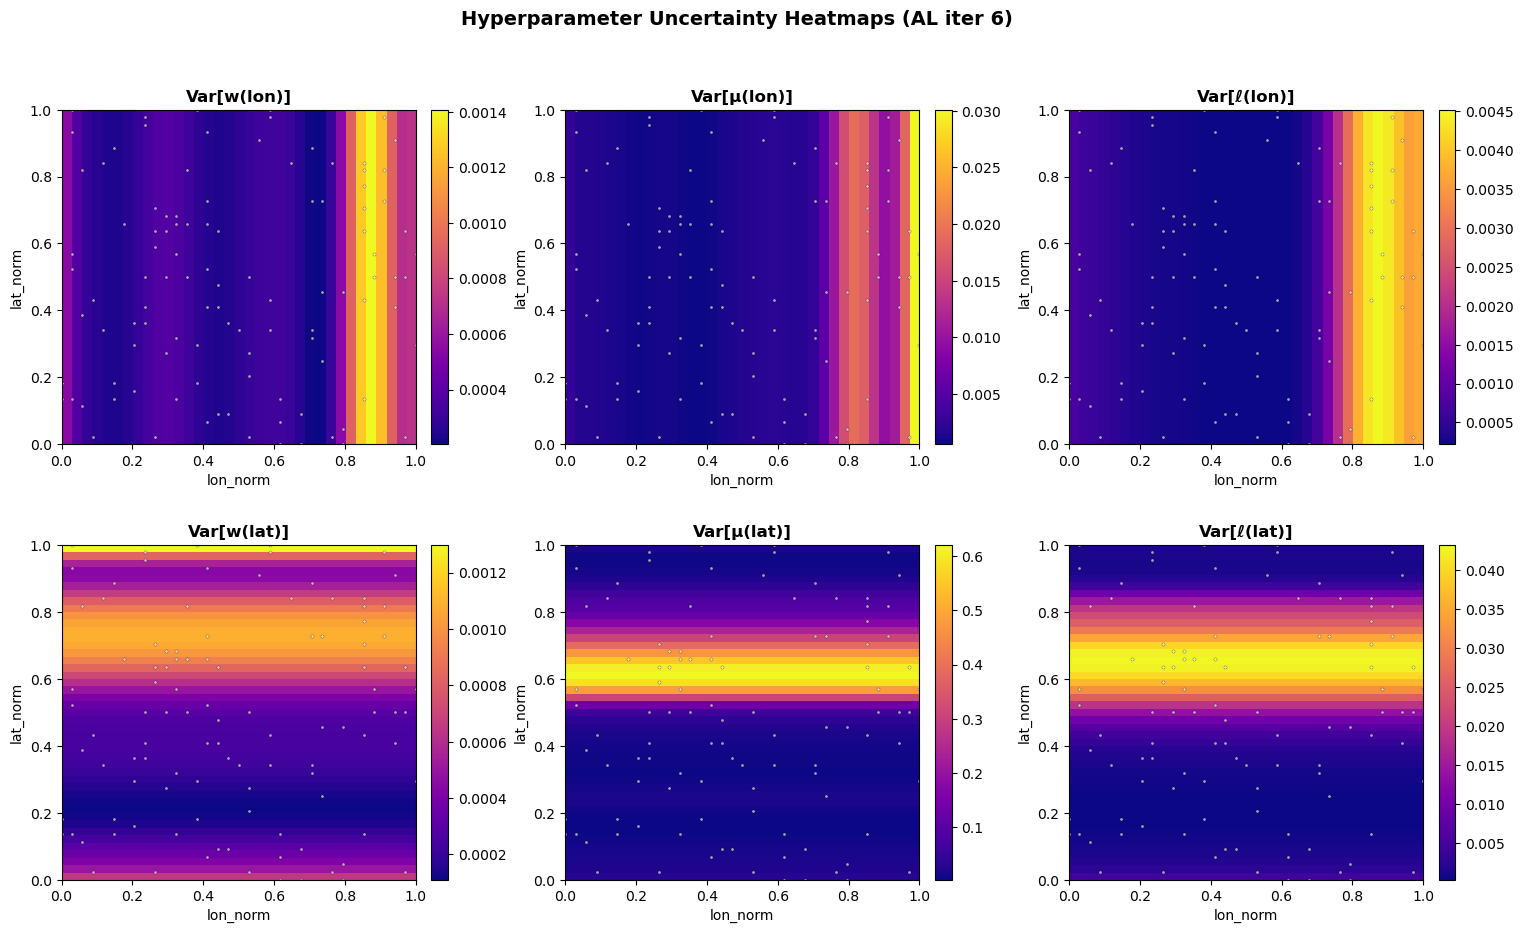

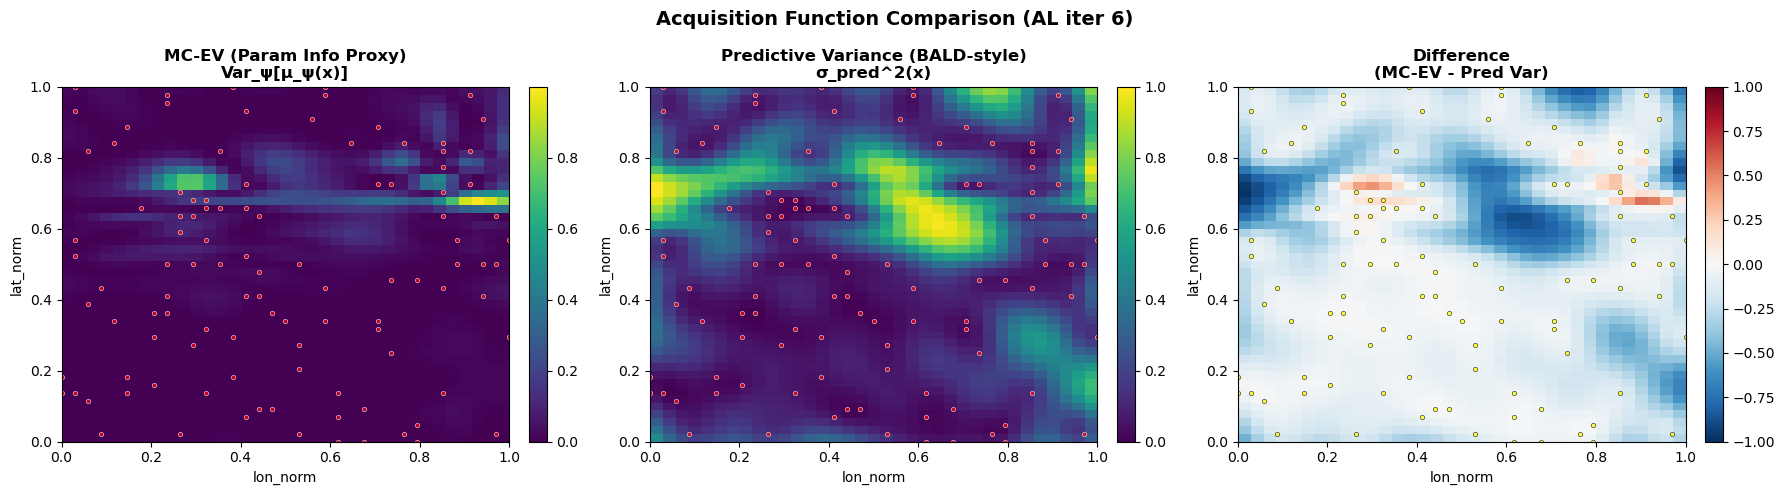

  Acquired via MC-EV (Param-Info Proxy): idx=1470, score=0.0149

AL ITERATION 7/8 (PARAMETER)
Current train size: 106

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.2866
    iter 100/150, loss=0.9073
    iter 150/150, loss=0.8091

  >>> Training GSM member 2/6
    iter 50/150, loss=1.2810
    iter 100/150, loss=0.9132
    iter 150/150, loss=0.8185

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3142
    iter 100/150, loss=0.9224
    iter 150/150, loss=0.8326

  >>> Training GSM member 4/6
    iter 50/150, loss=1.2985
    iter 100/150, loss=0.9130
    iter 150/150, loss=0.8240

  >>> Training GSM member 5/6
    iter 50/150, loss=1.2963
    iter 100/150, loss=0.9147
    iter 150/150, loss=0.8309

  >>> Training GSM member 6/6
    iter 50/150, loss=1.2397
    iter 100/150, loss=0.8933
    iter 150/150, loss=0.8002

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.8894
    SM iter 100/150, loss=0.8374
    SM iter

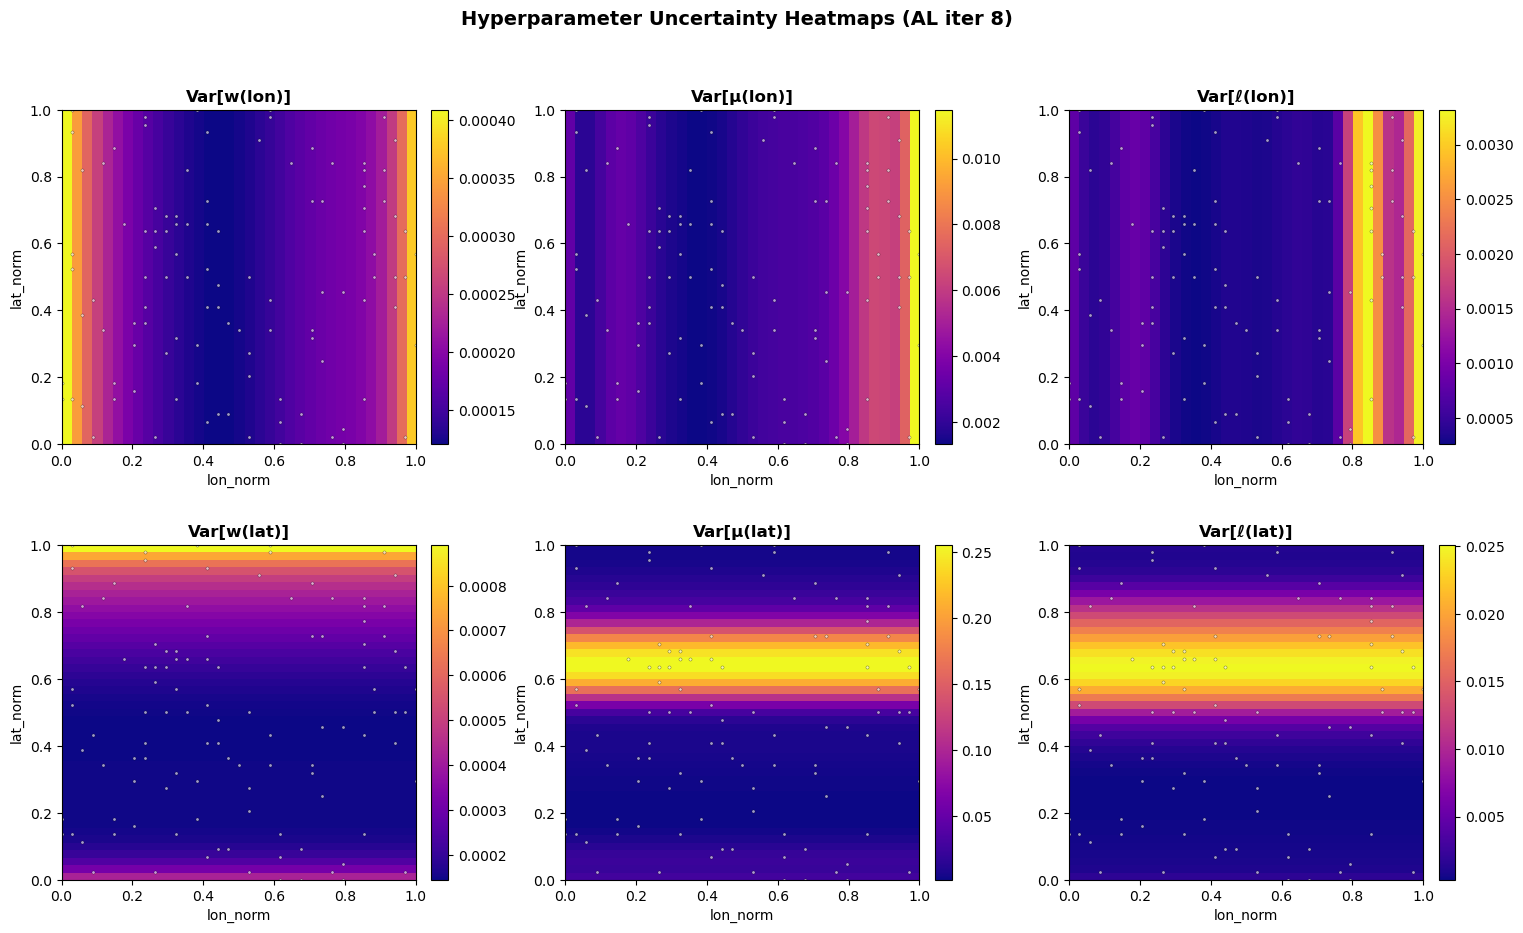

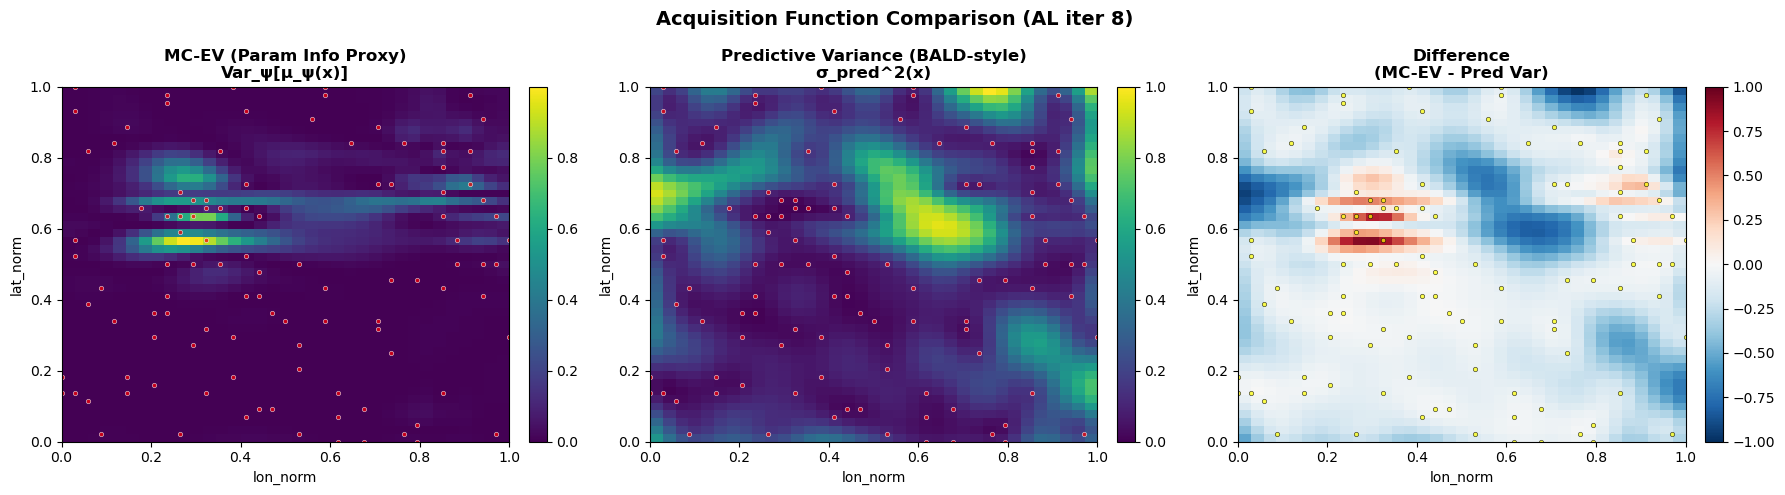

  Acquired via MC-EV (Param-Info Proxy): idx=430, score=0.0179

RUNNING: PREDICTIVE VARIANCE ACQUISITION (BALD-STYLE BASELINE)
Initial training set size: 100
Acquisition function: prediction

AL ITERATION 1/8 (PREDICTION)
Current train size: 100

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3580
    iter 100/150, loss=0.9249
    iter 150/150, loss=0.8208

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3374
    iter 100/150, loss=0.9165
    iter 150/150, loss=0.8183

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3155
    iter 100/150, loss=0.9066
    iter 150/150, loss=0.8086

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3504
    iter 100/150, loss=0.9523
    iter 150/150, loss=0.8405

  >>> Training GSM member 5/6
    iter 50/150, loss=1.2994
    iter 100/150, loss=0.9052
    iter 150/150, loss=0.8189

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3525
    iter 100/150, loss=0.9484
    iter 150/150, loss=

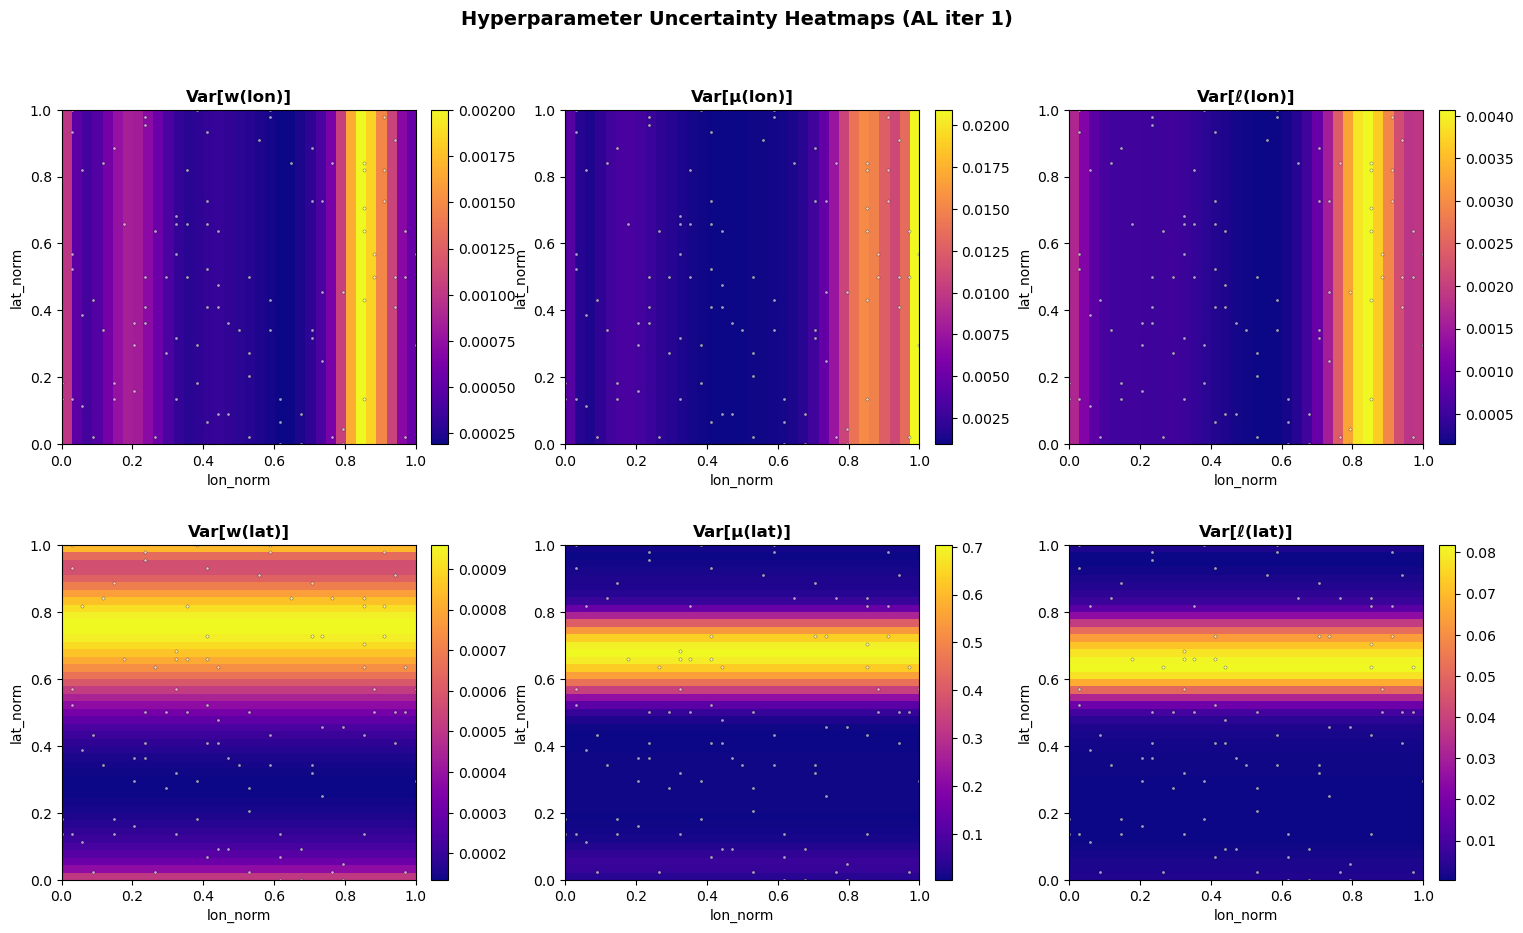

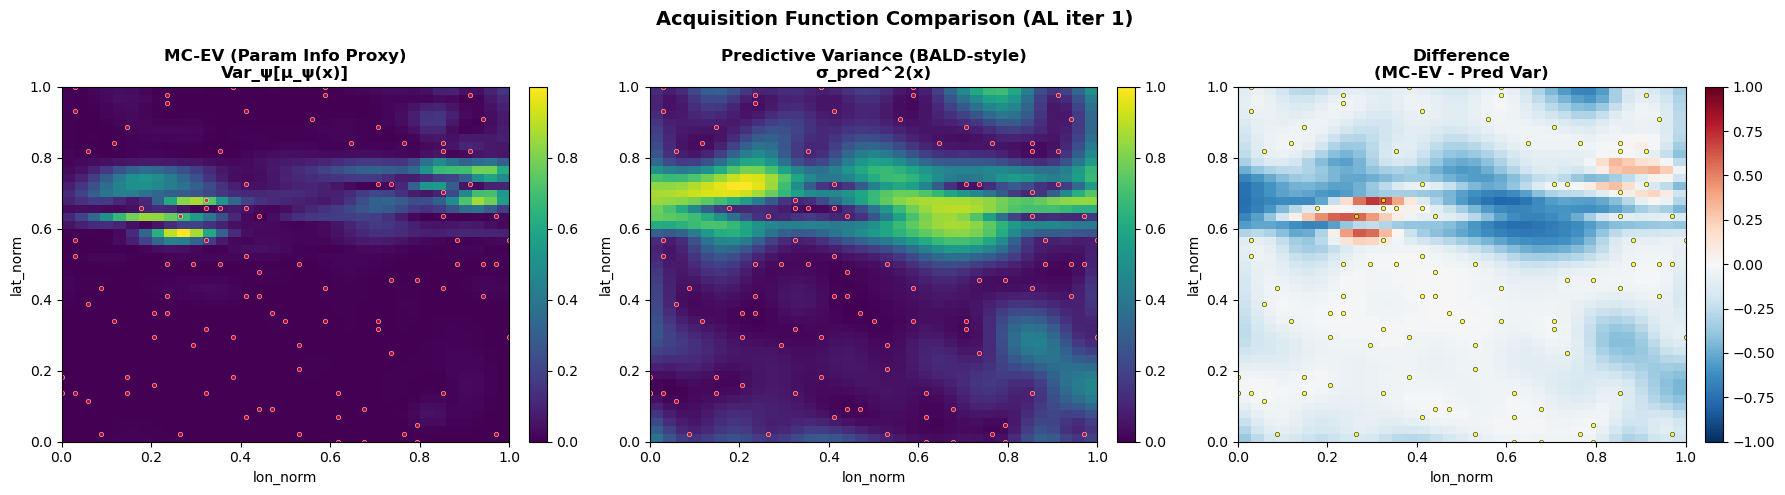

  Acquired via Predictive Variance (BALD-style): idx=347, score=0.7629

AL ITERATION 2/8 (PREDICTION)
Current train size: 101

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3323
    iter 100/150, loss=0.9441
    iter 150/150, loss=0.8572

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3522
    iter 100/150, loss=0.9497
    iter 150/150, loss=0.8658

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3060
    iter 100/150, loss=0.9196
    iter 150/150, loss=0.8392

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3223
    iter 100/150, loss=0.9436
    iter 150/150, loss=0.8618

  >>> Training GSM member 5/6
    iter 50/150, loss=1.3455
    iter 100/150, loss=0.9405
    iter 150/150, loss=0.8475

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3475
    iter 100/150, loss=0.9447
    iter 150/150, loss=0.8561

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.8397
    SM iter 100/150, loss=0.7284
   

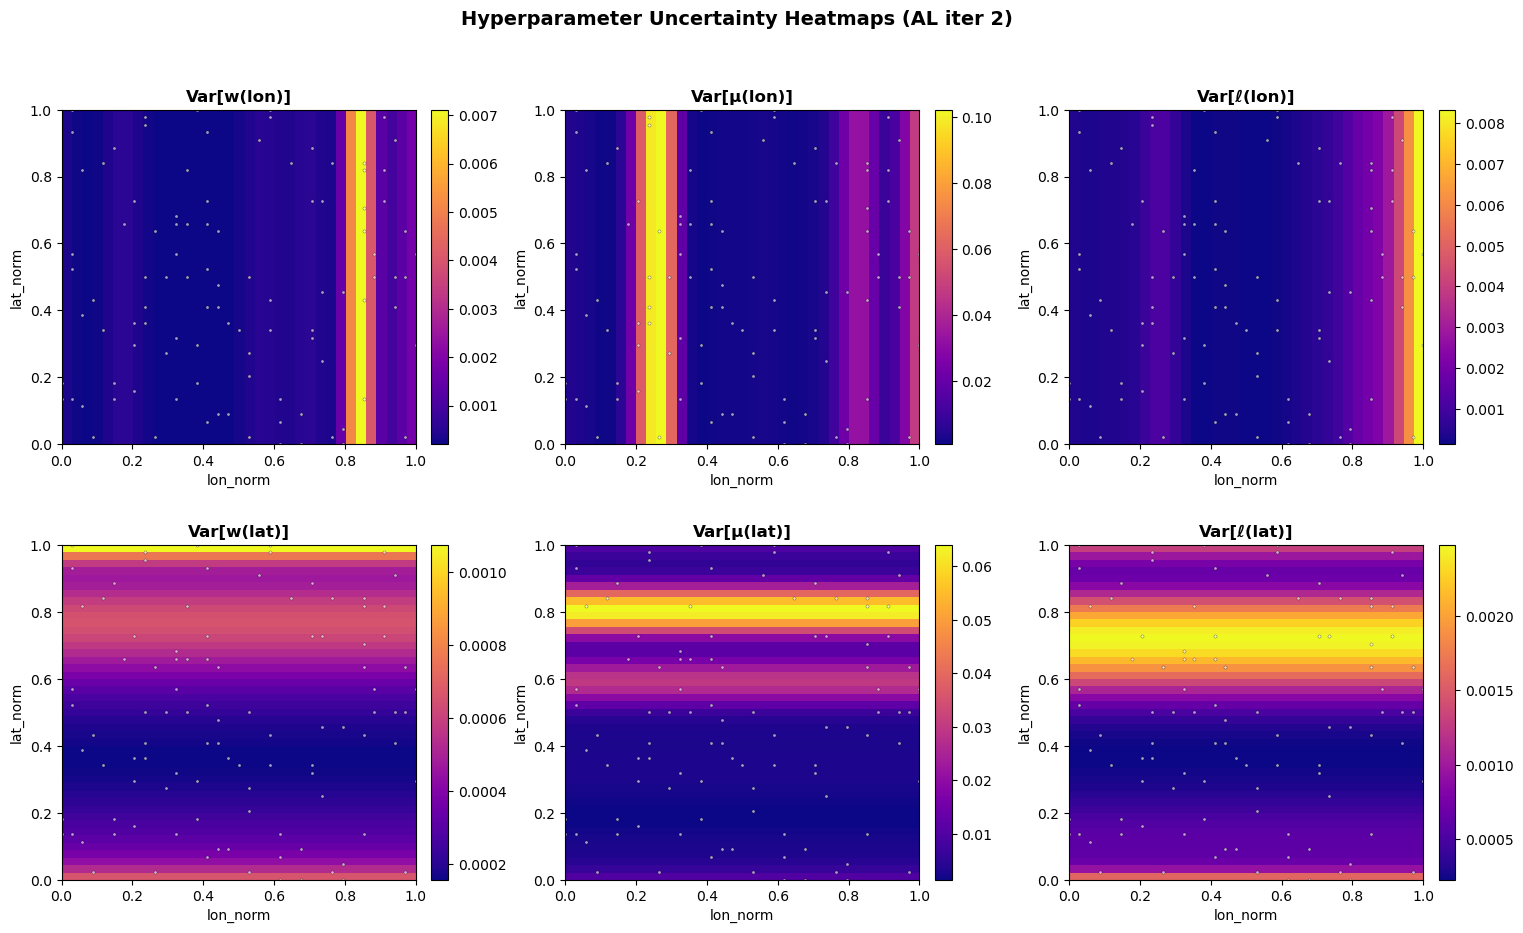

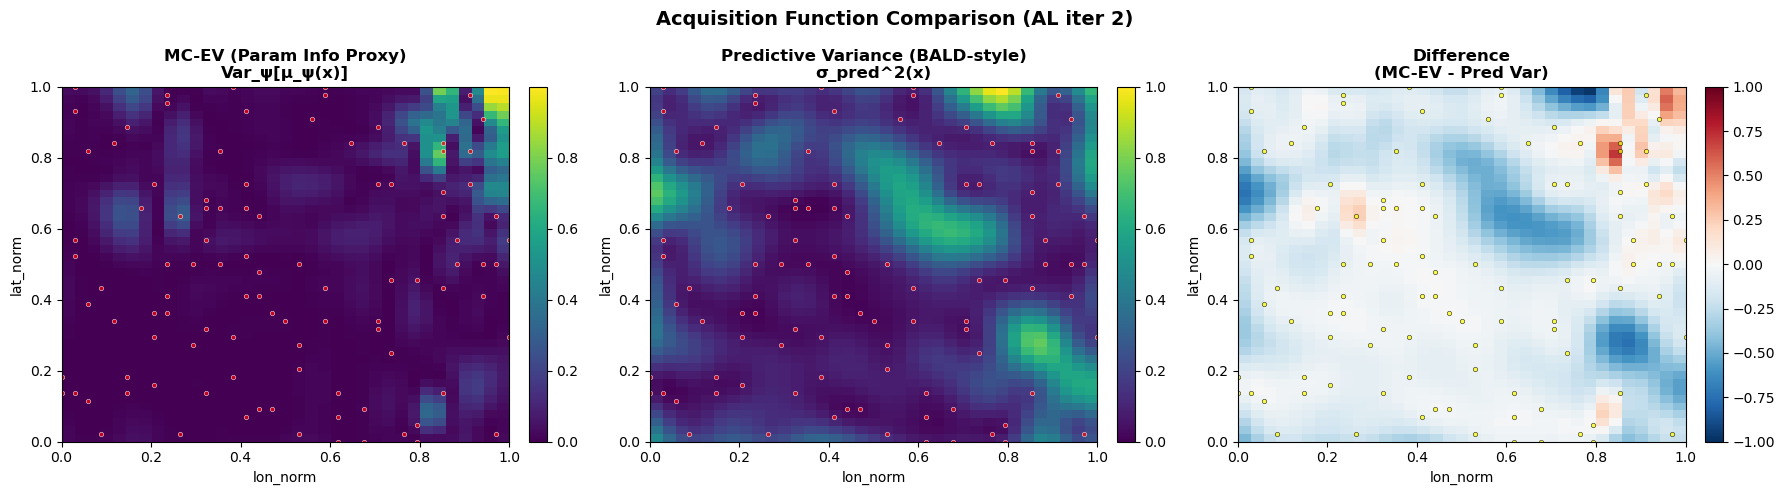

  Acquired via Predictive Variance (BALD-style): idx=1259, score=0.6799

AL ITERATION 3/8 (PREDICTION)
Current train size: 102

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3587
    iter 100/150, loss=0.9437
    iter 150/150, loss=0.8558

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3013
    iter 100/150, loss=0.9171
    iter 150/150, loss=0.8182

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3026
    iter 100/150, loss=0.9375
    iter 150/150, loss=0.8574

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3201
    iter 100/150, loss=0.9381
    iter 150/150, loss=0.8585

  >>> Training GSM member 5/6
    iter 50/150, loss=1.2898
    iter 100/150, loss=0.9333
    iter 150/150, loss=0.8468

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3627
    iter 100/150, loss=0.9216
    iter 150/150, loss=0.8238

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.8663
    SM iter 100/150, loss=0.7192
  

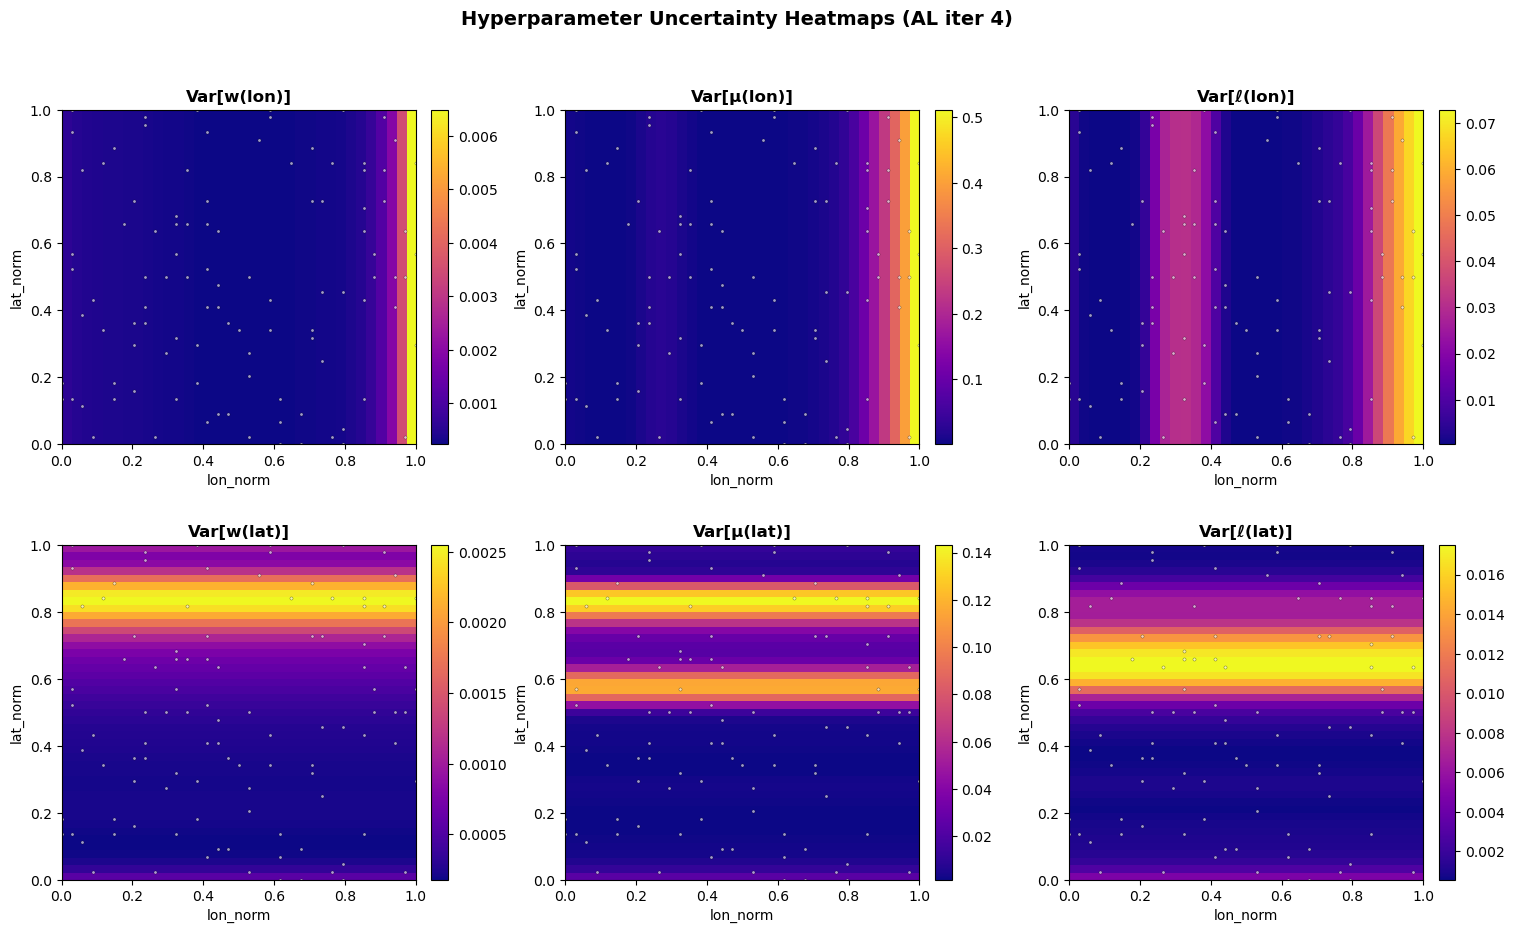

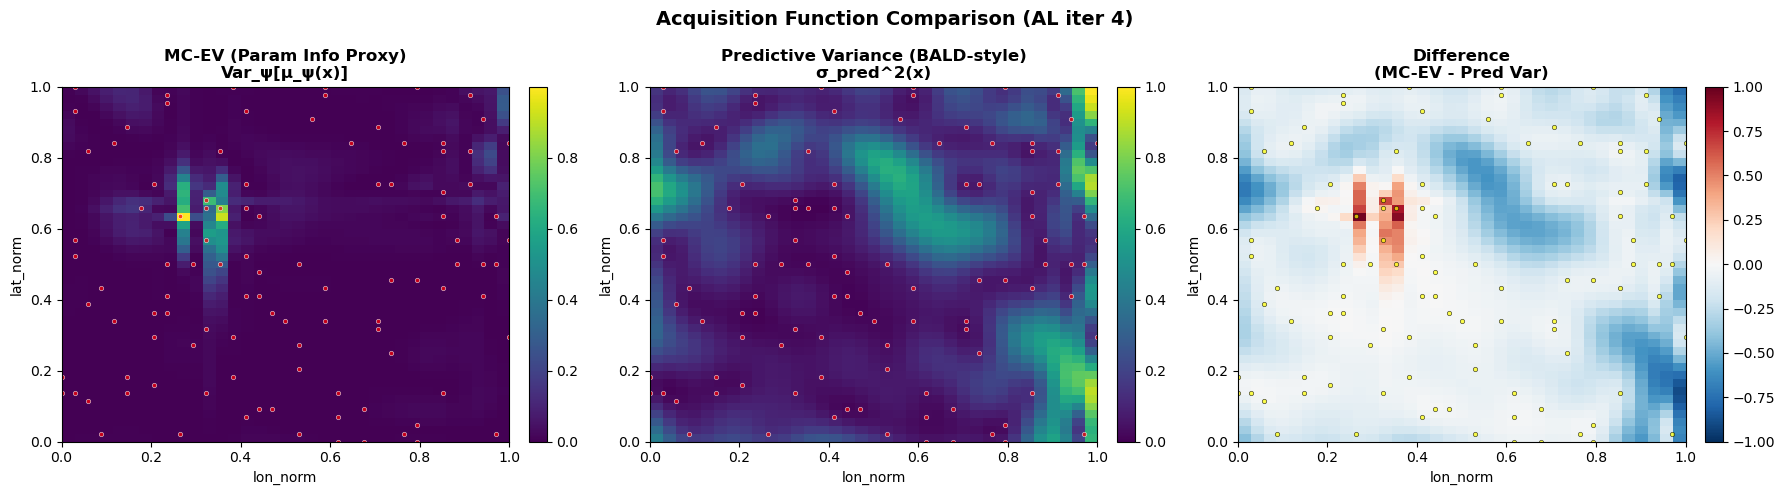

  Acquired via Predictive Variance (BALD-style): idx=1574, score=0.8041

AL ITERATION 5/8 (PREDICTION)
Current train size: 104

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3132
    iter 100/150, loss=0.9648
    iter 150/150, loss=0.8800

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3368
    iter 100/150, loss=0.9707
    iter 150/150, loss=0.8567

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3991
    iter 100/150, loss=0.9758
    iter 150/150, loss=0.8544

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3005
    iter 100/150, loss=0.9624
    iter 150/150, loss=0.8775

  >>> Training GSM member 5/6
    iter 50/150, loss=1.3093
    iter 100/150, loss=0.9330
    iter 150/150, loss=0.8448

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3099
    iter 100/150, loss=0.9302
    iter 150/150, loss=0.8442

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.9610
    SM iter 100/150, loss=0.7842
  

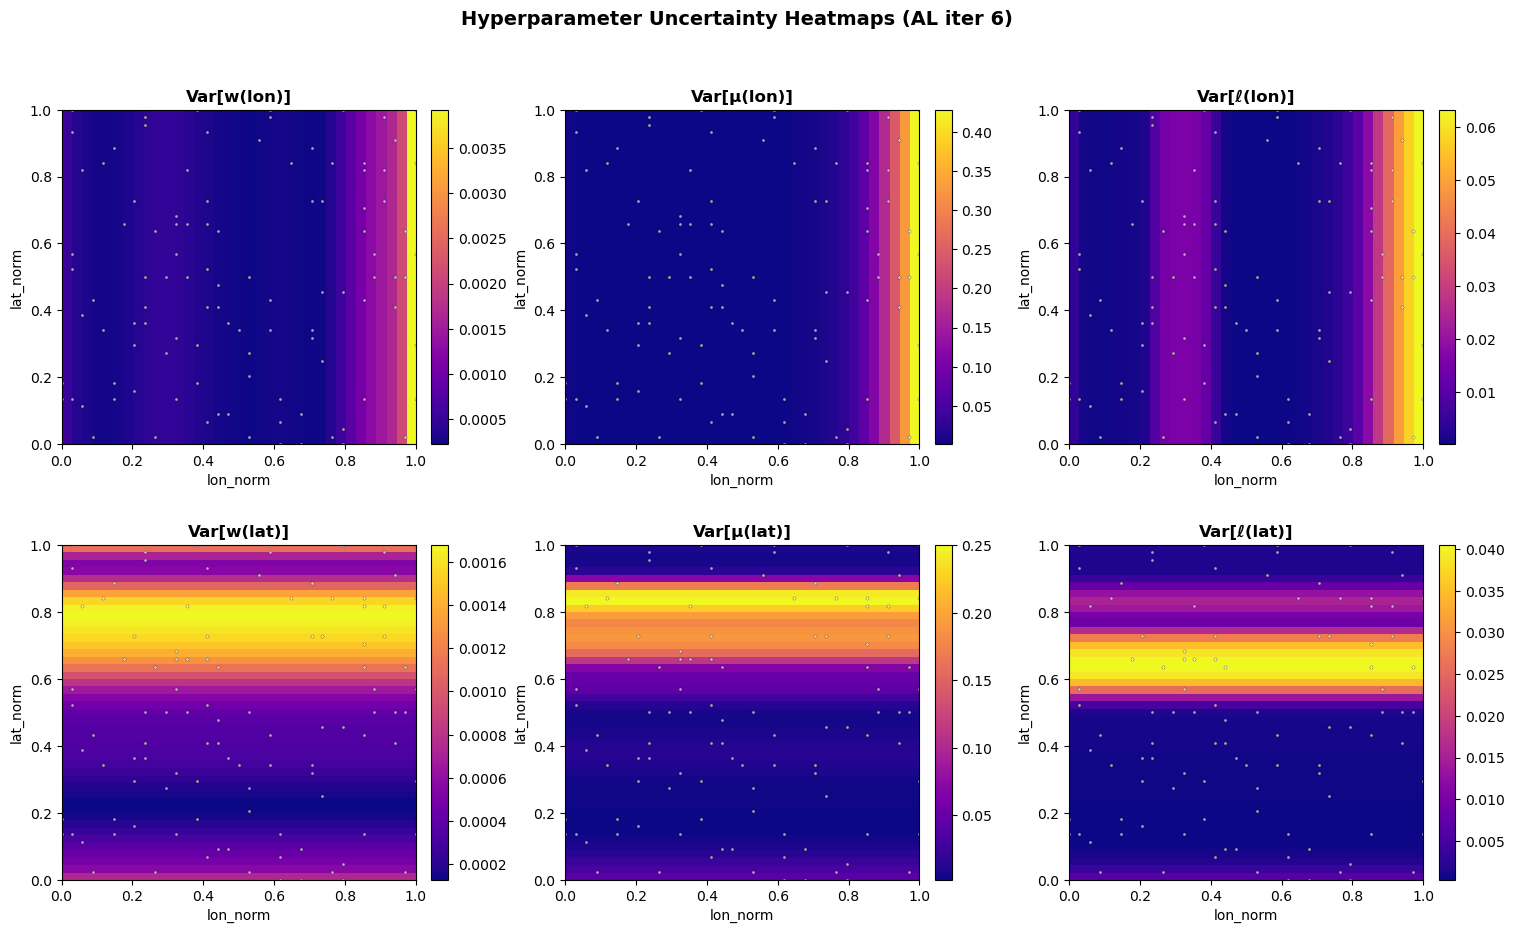

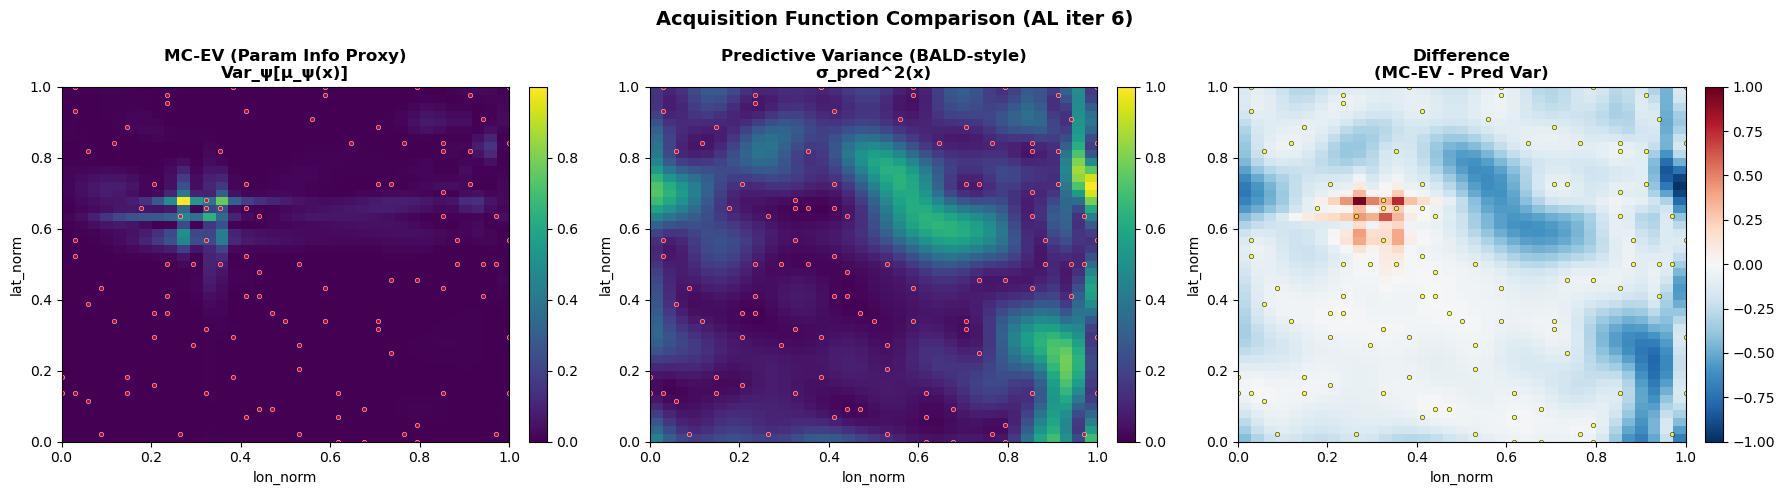

  Acquired via Predictive Variance (BALD-style): idx=1562, score=0.7417

AL ITERATION 7/8 (PREDICTION)
Current train size: 106

BUILDING GSM ENSEMBLE (multi-start MAP)

  >>> Training GSM member 1/6
    iter 50/150, loss=1.3521
    iter 100/150, loss=0.9624
    iter 150/150, loss=0.8577

  >>> Training GSM member 2/6
    iter 50/150, loss=1.3425
    iter 100/150, loss=0.9854
    iter 150/150, loss=0.8852

  >>> Training GSM member 3/6
    iter 50/150, loss=1.3743
    iter 100/150, loss=0.9831
    iter 150/150, loss=0.8569

  >>> Training GSM member 4/6
    iter 50/150, loss=1.3616
    iter 100/150, loss=0.9940
    iter 150/150, loss=0.8875

  >>> Training GSM member 5/6
    iter 50/150, loss=1.3614
    iter 100/150, loss=0.9876
    iter 150/150, loss=0.8870

  >>> Training GSM member 6/6
    iter 50/150, loss=1.3023
    iter 100/150, loss=0.9423
    iter 150/150, loss=0.8567

✓ Ensemble built.
  Training SM baseline...
    SM iter 50/150, loss=0.9614
    SM iter 100/150, loss=0.9206
  

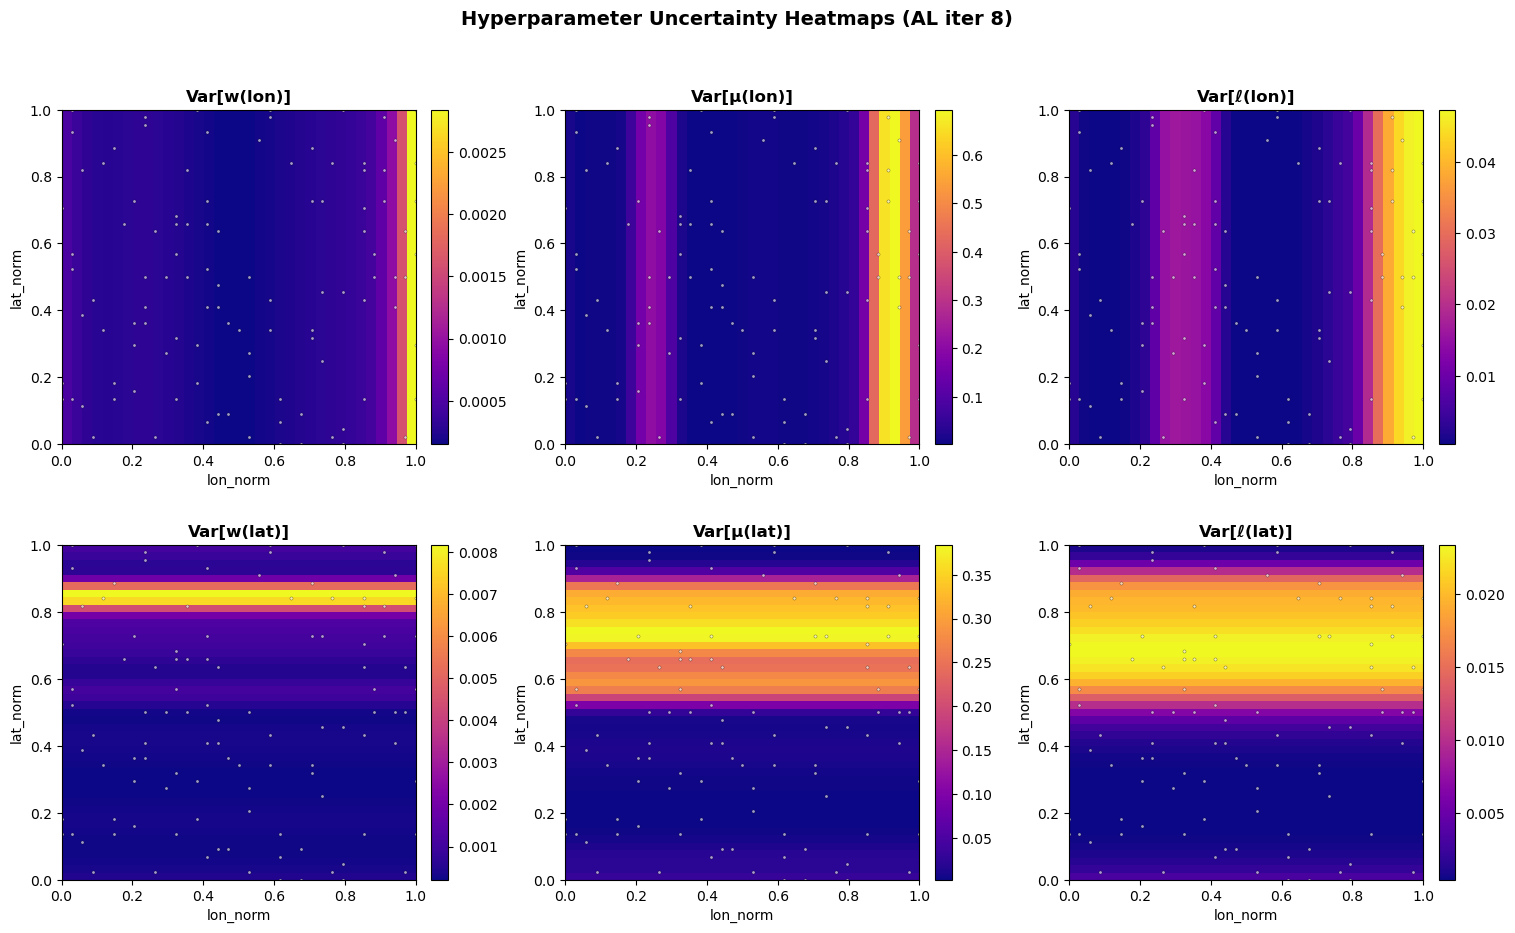

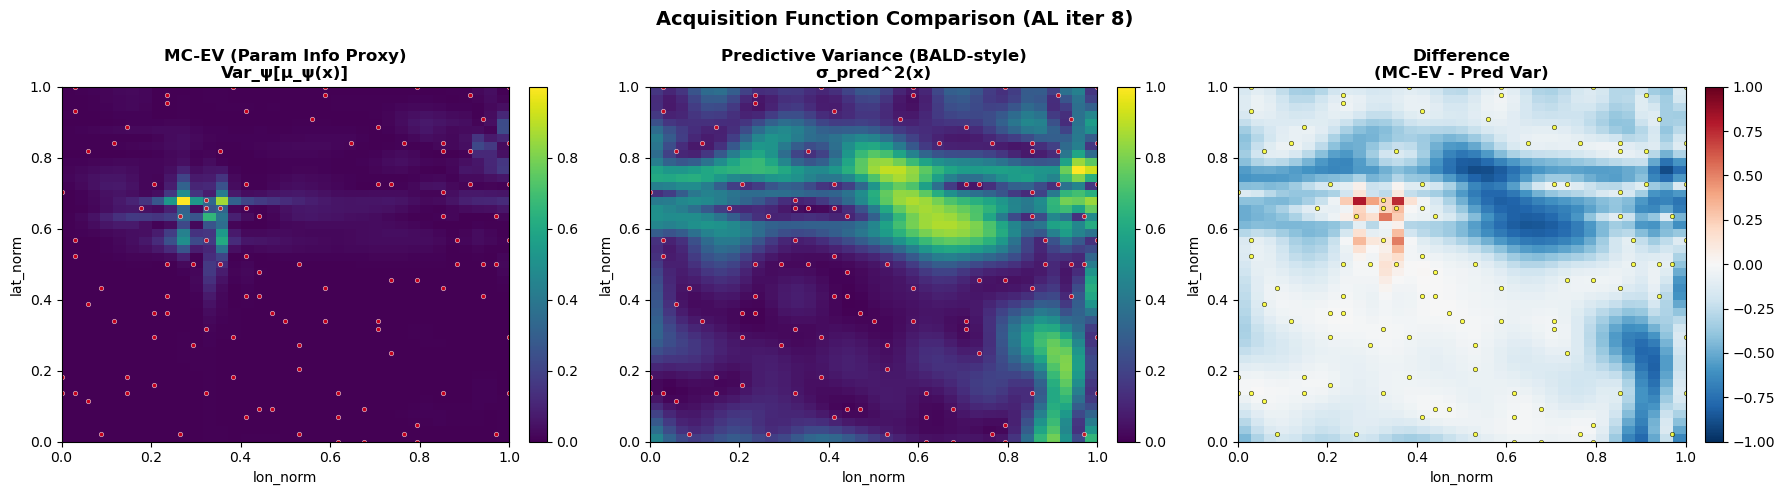

  Acquired via Predictive Variance (BALD-style): idx=1519, score=0.6453

GENERATING COMPREHENSIVE COMPARISON


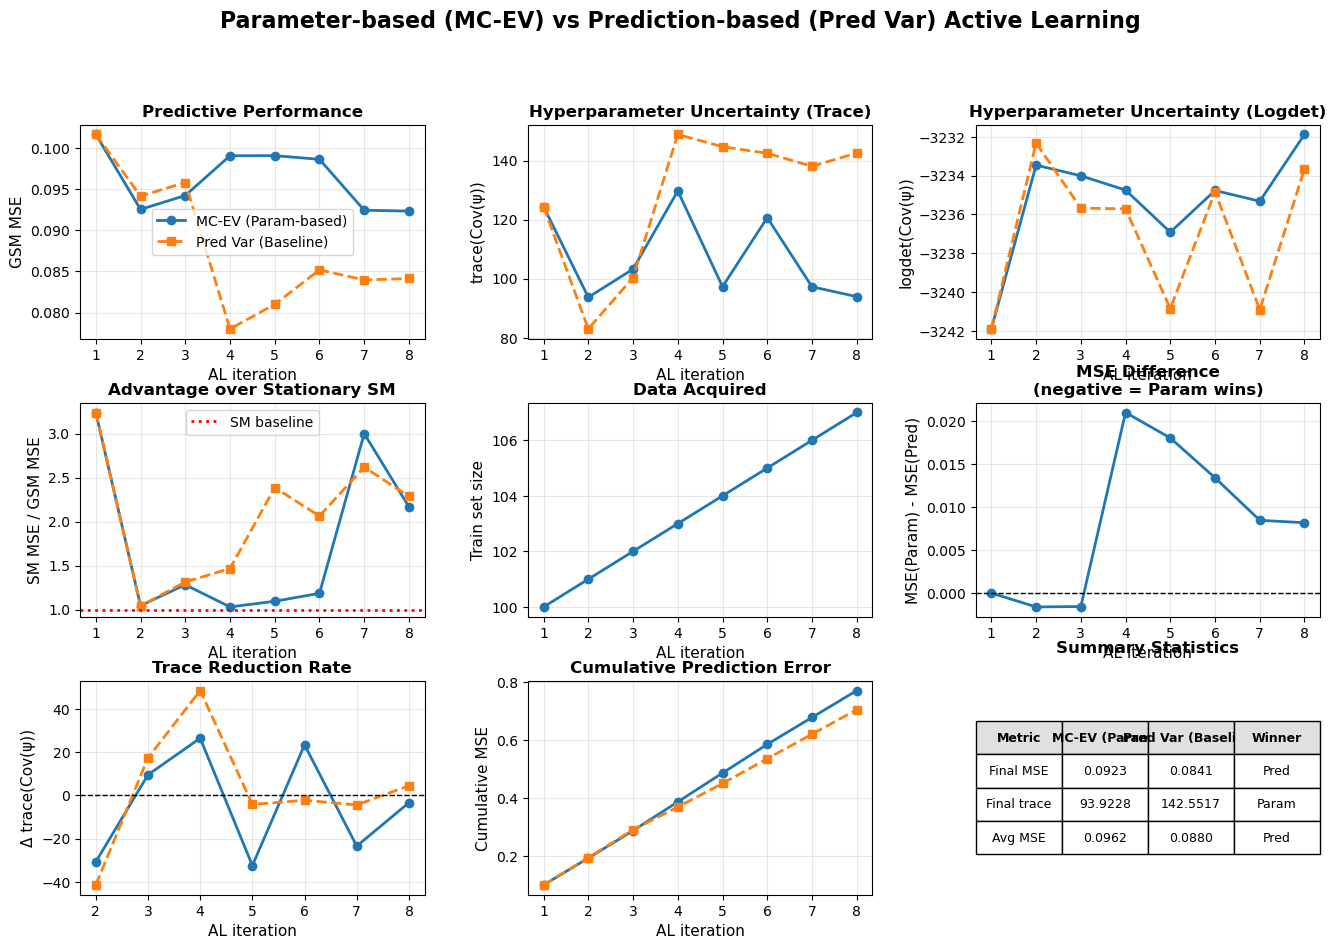


ACTIVE LEARNING EXPERIMENT COMPLETE!

Final Results:
  Parameter-based (MC-EV):
    - Final MSE: 0.0923
    - Final trace(Cov(ψ)): 93.9228
    - Avg MSE: 0.0962

  Prediction-based (Pred Var):
    - Final MSE: 0.0841
    - Final trace(Cov(ψ)): 142.5517
    - Avg MSE: 0.0880

  Winner (Final MSE): Prediction-based (Pred Var)
  Winner (Param Uncertainty): Parameter-based (MC-EV)



In [14]:
# ============================================================
# 11. MAIN EXECUTION
# ============================================================

if __name__ == "__main__":
    print("="*70)
    print("PARAMETER-INFORMATION ACTIVE LEARNING (MC-EV) VS PREDICTIVE VARIANCE")
    print("="*70)
    
    print("\nGenerating 2D geospatial-like dataset...")
    X_all, y_clean, y_noisy, lon_grid, lat_grid, n_lon, n_lat = generate_geospatial_grid(
        n_lon=35, n_lat=45, seed=42  # *** CHANGED: 35 x 45 grid
    )
    print(f"Full grid: {n_lat} x {n_lon} = {X_all.shape[0]} points in [0,1]²")

    # ============================================================
    # RUN PARAMETER-BASED AL (MC-EV)
    # ============================================================
    print("\n" + "="*70)
    print("RUNNING: PARAMETER INFORMATION ACQUISITION (MC-EV)")
    print("="*70)
    
    AL_param = ActiveLearner(
        X_all, y_clean, y_noisy, lon_grid, lat_grid, n_lon, n_lat,
        ensemble_size=6,
        num_mixtures=5,   # *** CHANGED: Q=5 GSM
        acquisition='parameter'
    )

    results_param = AL_param.run(
        num_init=100,
        num_steps=8,
        seed=123,
        plot_every=2
    )

    # ============================================================
    # RUN PREDICTION-BASED AL (PREDICTIVE VARIANCE / BALD-STYLE)
    # ============================================================
    print("\n" + "="*70)
    print("RUNNING: PREDICTIVE VARIANCE ACQUISITION (BALD-STYLE BASELINE)")
    print("="*70)
    
    AL_pred = ActiveLearner(
        X_all, y_clean, y_noisy, lon_grid, lat_grid, n_lon, n_lat,
        ensemble_size=6,
        num_mixtures=5,   # *** CHANGED: same GSM architecture
        acquisition='prediction'
    )

    results_pred = AL_pred.run(
        num_init=100,
        num_steps=8,
        seed=123,
        plot_every=2
    )

    # ============================================================
    # FINAL COMPARISON PLOT
    # ============================================================
    print("\n" + "="*70)
    print("GENERATING COMPREHENSIVE COMPARISON")
    print("="*70)
    
    plot_learning_curves_comparison(
        results_param, 
        results_pred,
        save_path='final_comparison_param_vs_pred.png'
    )

    print("\n" + "="*70)
    print("ACTIVE LEARNING EXPERIMENT COMPLETE!")
    print("="*70)
    print(f"\nFinal Results:")
    print(f"  Parameter-based (MC-EV):")
    print(f"    - Final MSE: {results_param['mse_gsm'][-1]:.4f}")
    print(f"    - Final trace(Cov(ψ)): {results_param['trace_cov'][-1]:.4f}")
    print(f"    - Avg MSE: {np.mean(results_param['mse_gsm']):.4f}")
    print(f"\n  Prediction-based (Pred Var):")
    print(f"    - Final MSE: {results_pred['mse_gsm'][-1]:.4f}")
    print(f"    - Final trace(Cov(ψ)): {results_pred['trace_cov'][-1]:.4f}")
    print(f"    - Avg MSE: {np.mean(results_pred['mse_gsm']):.4f}")
    
    winner_mse = "Parameter-based (MC-EV)" if results_param['mse_gsm'][-1] < results_pred['mse_gsm'][-1] else "Prediction-based (Pred Var)"
    winner_trace = "Parameter-based (MC-EV)" if results_param['trace_cov'][-1] < results_pred['trace_cov'][-1] else "Prediction-based (Pred Var)"
    
    print(f"\n  Winner (Final MSE): {winner_mse}")
    print(f"  Winner (Param Uncertainty): {winner_trace}")
    print("\n" + "="*70)